In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 200)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import optuna
import shap

In [2]:
datadict = pd.read_csv('Data Dictionary.csv')
print("Data dictionary shape: ",datadict.shape)
datadict.head()

Data dictionary shape:  (188, 6)


,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


In [3]:
# loading dataset
dataset = pd.read_csv('Dataset.csv')
print("Dataset shape: ", dataset.shape)
dataset.head()

Dataset shape:  (91713, 186)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

Data contains 91713 samples and 186 features. Target is categorical.

In [4]:
# Creating a copy of dataset
df = dataset.copy()

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    encounter_id                   int64  
 1    patient_id                     int64  
 2    hospital_id                    int64  
 3    hospital_death                 int64  
 4    age                            float64
 5    bmi                            float64
 6    elective_surgery               int64  
 7    ethnicity                      object 
 8    gender                         object 
 9    height                         float64
 10   hospital_admit_source          object 
 11   icu_admit_source               object 
 12   icu_id                         int64  
 13   icu_stay_type                  object 
 14   icu_type                       object 
 15   pre_icu_los_days               float64
 16   readmission_status             int64  
 17   weight                       

In [6]:
# converting all objects to category
for col in df:
    if df[col].dtypes == 'object':
        df[col] = df[col].astype('category')

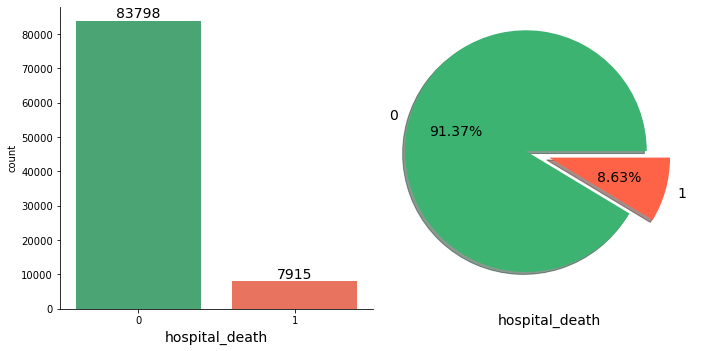

In [7]:
# Function for observing the target
def view_target_cat(df, target):
    # subplots
    plt.figure(figsize=(10,5))
    # barplot
    ax1 = plt.subplot(1,2,1)
    cp = sns.countplot(x=df[target], palette=['MediumSeaGreen', 'Tomato'])
    ax1.set_xlabel(target, fontsize=14)
    # setting values over barplot
    sizes = []
    for p in cp.patches:
        height = p.get_height()
        sizes.append(height)
        cp.text(p.get_x() + p.get_width()/2, 
                height + 1000,
                '{}'.format(height),
                ha='center',
                fontsize=14)
    sns.despine(top=True, right=True)
    # pieplot
    ax2 = plt.subplot(1,2,2)
    plt.pie(df[target].value_counts(),
            labels=list(df[target].unique()),
            colors=['MediumSeaGreen', 'Tomato'],
            autopct='%2.2f%%', 
            explode=(0.2,0),
            shadow=True,
            textprops={'fontsize':14}
           )
    ax2.set_xlabel(target, fontsize=14)
    plt.tight_layout()
    
view_target_cat(df, 'hospital_death')

In [8]:
# checking duplicates
df.duplicated().sum()

0

In [9]:
# checking constant features
[col for col in df if df[col].nunique()==1]

['readmission_status']

In [10]:
# dropping 'readmission_status'
def drop_features(df, feats):
    for feat in feats:
        df = df.drop(feat, axis=1)
    return df

df = drop_features(df,['readmission_status'])

In [11]:
# checking missing values
missing_feats = list(df.columns[df.isnull().any()])
missing_feats

['age',
 'bmi',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 '

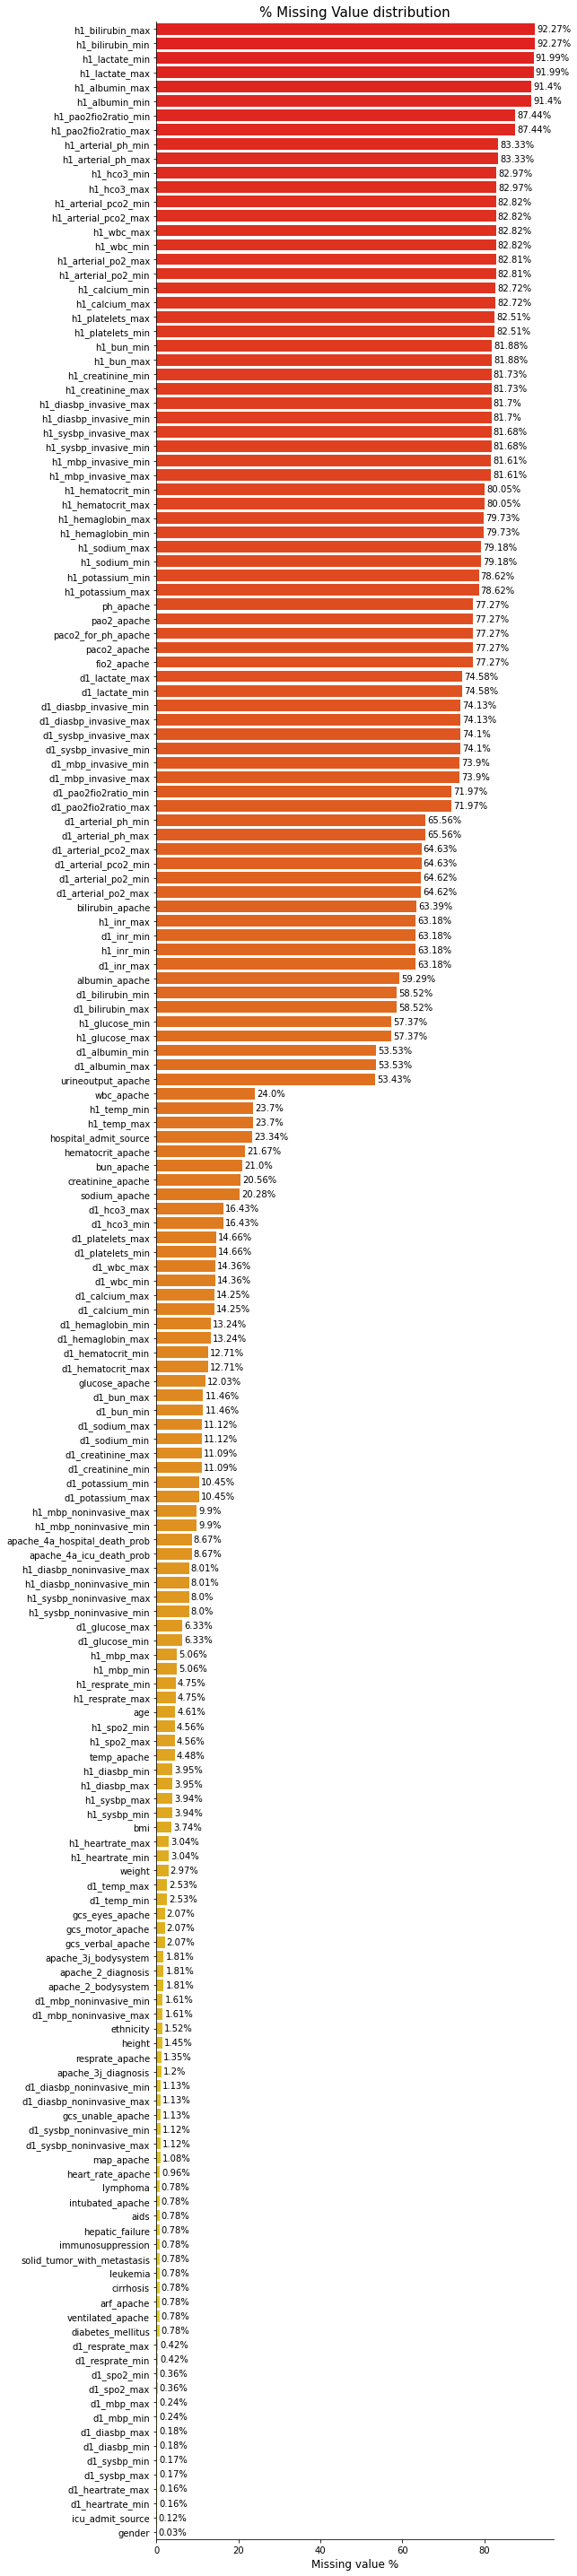

In [12]:
# Plotting missing values
def plot_missing(df, figsize=(9,40)):
    df_missing = df.isnull().mean()
    df_missing = df_missing[df_missing>0]
    fig,ax=plt.subplots(figsize=figsize)
    sns.barplot(x=100*df_missing.values, 
                y=df_missing.index, palette='autumn',
                order=df_missing.sort_values(ascending=False).index
               )
    for p in ax.patches:
        _x = p.get_x() + (p.get_width()*1) + (df_missing.values.max())*0.5
        _y = p.get_y() + p.get_height()/2
        value = str(round(float(p.get_width()),2))+"%"
        ax.text(_x, _y, value, ha="left", va='center')
    sns.despine()
    plt.title('% Missing Value distribution', fontsize=15)
    plt.xlabel('Missing value %', fontsize=12)
    plt.tight_layout()

plot_missing(df)

In [13]:
# dropping features with more than 8% missing values
def drop_features_on_threshold(df, t=0.08):
    thresh = len(df)*(1-t)
    df = df.dropna(axis=1, thresh=thresh)
    return df

df = drop_features_on_threshold(df)
print(df.shape)

(91713, 74)


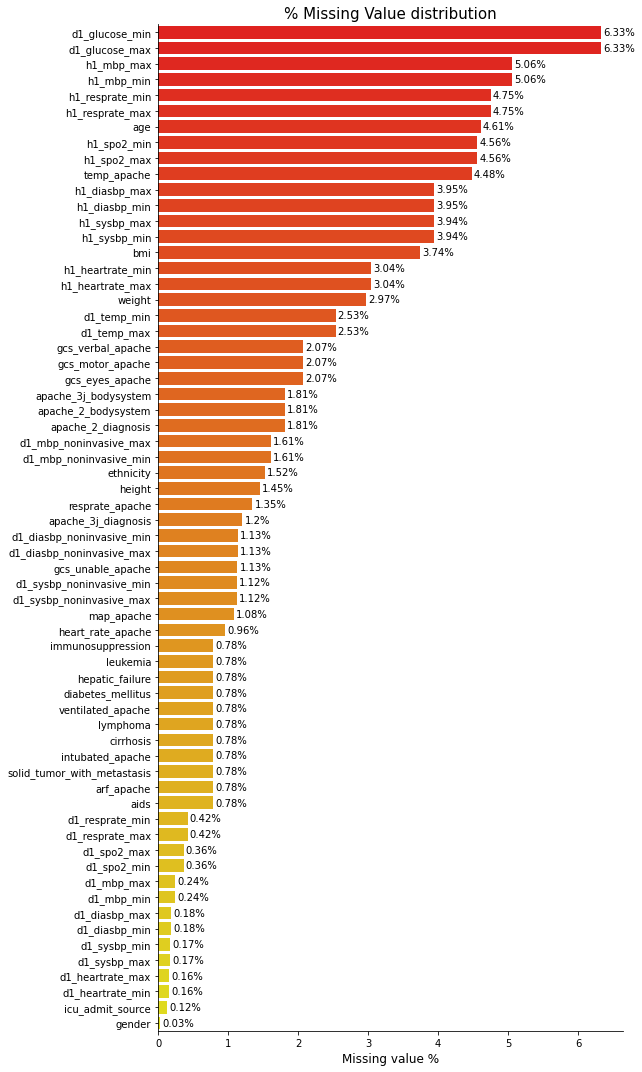

In [14]:
plot_missing(df, figsize=(9,15))

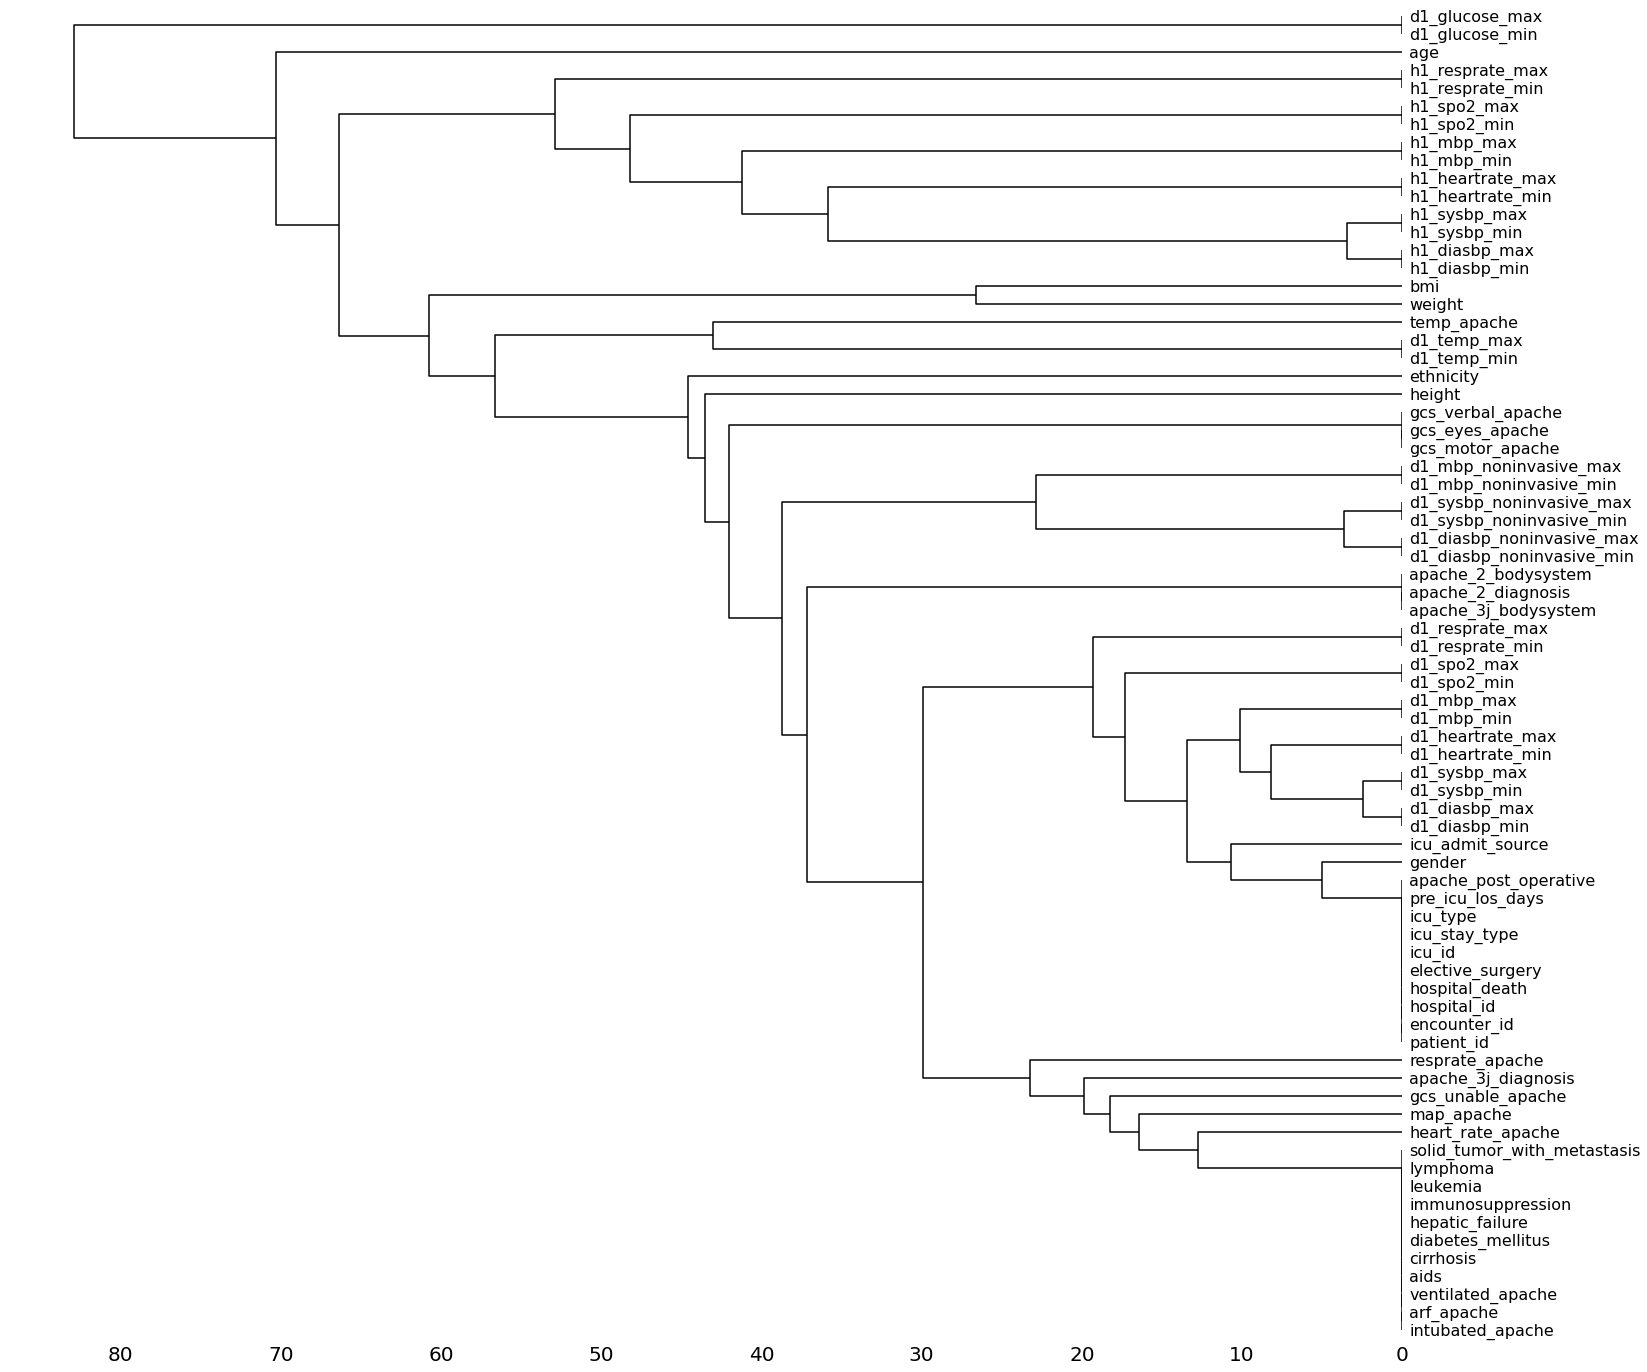

In [15]:
# Plotting missing value dendrogram
msno.dendrogram(df);

In [16]:
# Extracting numerical features
numfeat = df.select_dtypes(['int64', 'float64']).columns
numfeat

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days',
       'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'heart_rate_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_heartrate_max',
       'h1_heartrate_min', '

In [17]:
# Extracting discrete numerical features
discfeat = [feat for feat in numfeat if df[feat].nunique()<25]
discfeat

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [18]:
# Extracting continuous numerical features
contfeat = [feat for feat in numfeat if feat not in discfeat]
contfeat

['encounter_id',
 'patient_id',
 'hospital_id',
 'age',
 'bmi',
 'height',
 'icu_id',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'd1_glucose_max',
 'd1_glucose_min']

In [19]:
# Extracting categorical features
catfeat = df.select_dtypes(['category', 'object']).columns
catfeat

Index(['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type',
       'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')

In [20]:
# continuous numerical dataset
dnum = dataset[contfeat]
print(dnum.shape)
dnum.head()

(91713, 49)


,encounter_id,patient_id,hospital_id,age,bmi,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_glucose_max,d1_glucose_min
0,66154,25312,118,68.0,22.73,180.3,92,0.541667,73.9,113.0,502.01,118.0,40.0,36.0,39.3,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,119.0,108.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,168.0,109.0
1,114252,59342,81,77.0,27.42,160.0,90,0.927778,70.2,108.0,203.01,120.0,46.0,33.0,35.1,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,114.0,100.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,145.0,128.0
2,119783,50777,118,25.0,31.95,172.7,93,0.000694,95.3,122.0,703.03,102.0,68.0,37.0,36.7,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,96.0,78.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,NaN,NaN
3,79267,46918,118,81.0,22.64,165.1,92,0.000694,61.7,203.0,1206.03,114.0,60.0,4.0,34.8,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,100.0,96.0,92.0,71.0,12.0,11.0,100.0,99.0,136.0,106.0,185.0,88.0
4,92056,34377,33,19.0,NaN,188.0,91,0.073611,NaN,119.0,601.01,60.0,103.0,16.0,36.7,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,147.0,120.0,147.0,120.0,37.2,36.7,99.0,68.0,89.0,76.0,104.0,92.0,NaN,NaN,100.0,100.0,130.0,120.0,NaN,NaN


In [21]:
# discrete dataset
ddis = dataset[discfeat]
print(ddis.shape)
ddis.head()

(91713, 18)


,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,0,0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0.0,3.0,6.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,0.0,4.0,6.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# categorical dataset
dcat = dataset[catfeat]
print(dcat.shape)
dcat.head()

(91713, 7)


,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma


In [23]:
# checking discrete feature dtypes
ddis.dtypes

hospital_death                   int64
elective_surgery                 int64
apache_post_operative            int64
arf_apache                     float64
gcs_eyes_apache                float64
gcs_motor_apache               float64
gcs_unable_apache              float64
gcs_verbal_apache              float64
intubated_apache               float64
ventilated_apache              float64
aids                           float64
cirrhosis                      float64
diabetes_mellitus              float64
hepatic_failure                float64
immunosuppression              float64
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
dtype: object

In [24]:
# changing discrete features to type 'categorical'
for col in ddis:
    ddis[col] = ddis[col].astype('category')

In [25]:
# Merging all discrete features to categorical type
dcat = pd.concat([dcat, ddis], axis=1)
dcat.head()

,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,Caucasian,M,Floor,admit,CTICU,Sepsis,Cardiovascular,0,0,0,0.0,3.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Caucasian,F,Floor,admit,Med-Surg ICU,Respiratory,Respiratory,0,0,0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic,0,0,0,0.0,3.0,6.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Caucasian,F,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular,0,1,1,0.0,4.0,6.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma,0,0,0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploration

### Numerical Features

In [26]:
dnum.describe()

,encounter_id,patient_id,hospital_id,age,bmi,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_glucose_max,d1_glucose_min
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,90379.000000,91713.000000,91713.000000,88993.000000,90051.000000,90612.000000,90835.000000,90719.000000,90479.000000,87605.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,88094.000000,88094.000000,88923.000000,88923.000000,87074.000000,87074.000000,87356.000000,87356.000000,87528.000000,87528.000000,88102.000000,88102.000000,85906.000000,85906.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,169.641588,508.357692,0.835766,84.028340,185.401739,558.216377,99.707932,88.015873,25.811007,36.414472,88.491873,50.161314,88.610513,50.242597,103.000568,70.321848,104.651339,64.871859,104.590454,64.941541,28.882774,12.846279,99.241836,90.454826,148.339745,96.92387,148.235549,96.993313,37.284201,36.268391,75.354508,62.838150,92.229198,83.663720,91.612950,79.400028,22.633614,17.211525,98.044637,95.174310,133.247395,116.362296,174.638023,114.380940
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,10.795378,228.989661,2.487756,25.011497,86.050882,463.266985,30.870502,42.032412,15.106312,0.833496,19.798379,13.317586,19.793743,13.341521,22.017346,17.115903,20.808358,15.679680,20.701171,15.701305,10.701973,5.064943,1.794181,10.030069,25.733259,20.67793,25.792453,20.705016,0.693287,0.745147,18.409190,16.363229,21.823704,20.279869,20.533174,19.130590,7.515043,6.072588,3.212934,6.625227,27.556986,26.510637,86.687955,38.273013
min,1.000000,1.000000,2.000000,16.000000,14.844926,137.200000,82.000000,-24.947222,38.600000,101.000000,0.010000,30.000000,40.000000,4.000000,32.100000,46.000000,13.000000,46.000000,13.000000,58.000000,0.000000,60.000000,22.000000,60.000000,22.000000,14.000000,0.000000,0.000000,0.000000,90.000000,41.00000,90.000000,41.030000,35.100000,31.889000,37.000000,22.000000,46.000000,36.000000,49.000000,32.000000,10.000000,0.000000,0.000000,0.000000,75.000000,53.000000,73.000000,33.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,162.500000,369.000000,0.035417,66.800000,113.000000,203.010000,86.000000,54.000000,11.000000,36.200000,75.000000,42.000000,75.000000,42.000000,87.000000,60.000000,90.000000,55.000000,90.000000,55.000000,22.000000,10.000000,99.000000,89.000000,130.000000,83.00000,130.000000,84.000000,36.900000,36.100000,62.000000,52.000000,77.000000,69.000000,77.000000,66.000000,18.000000,14.000000,97.000000,94.000000,113.000000,98.000000,117.000000,91.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,170.100000,504.000000,0.138889,80.300000,122.000000,409.020000,104.000000,67.000000,28.000000,36.500000,86.000000,50.000000,87.000000,50.000000,101.000000,69.000000,102.000000,64.000000,102.000000,64.000000,26.000000,13.000000,100.000000,92.000000,146.000000,96.00000,146.000000,96.000000,37.110000,36.400000,74.000000,62.000000,90.000000,82.000000,90.000000,78.000000,21.000000,16.000000,99.000000,96.000000,131.000000,115.000000,150.000000,107.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,177.800000,679.000000,0.409028,97.100000,301.000000,703.030000,120.000000,125

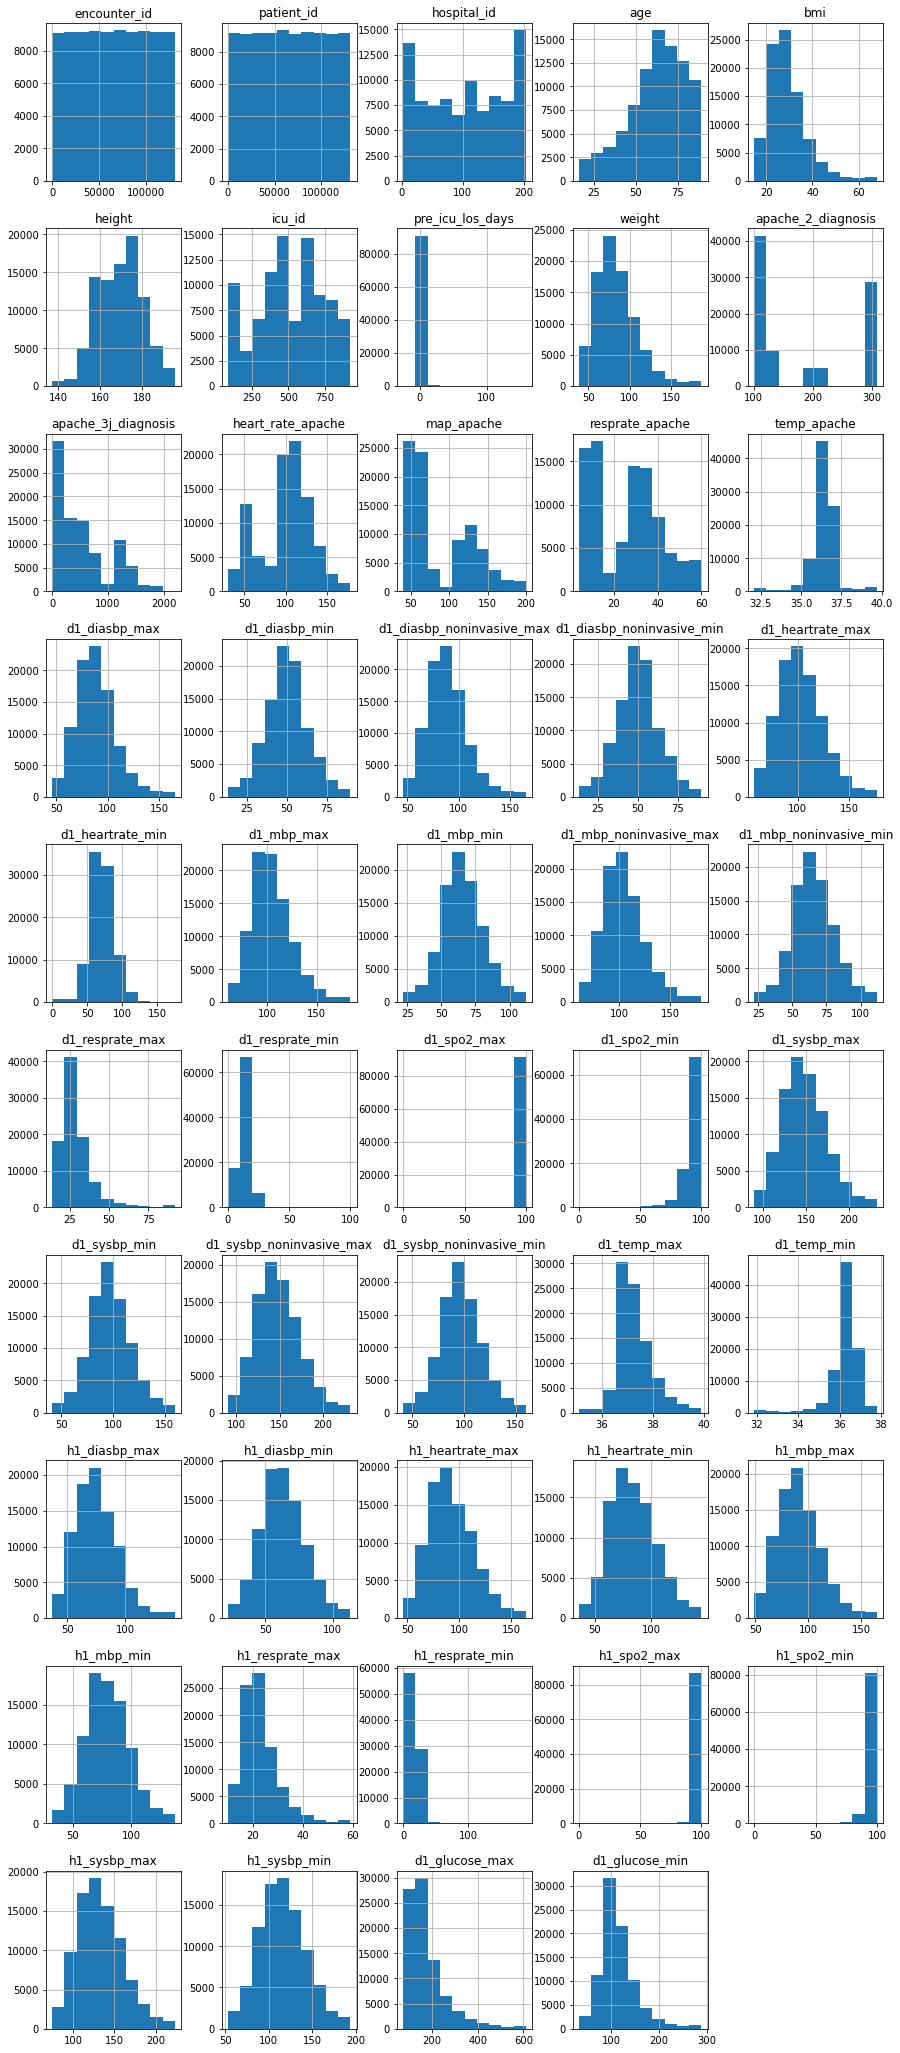

In [27]:
# Observing feature distribution
dnum.hist(layout=(32,5), figsize=(15,120));

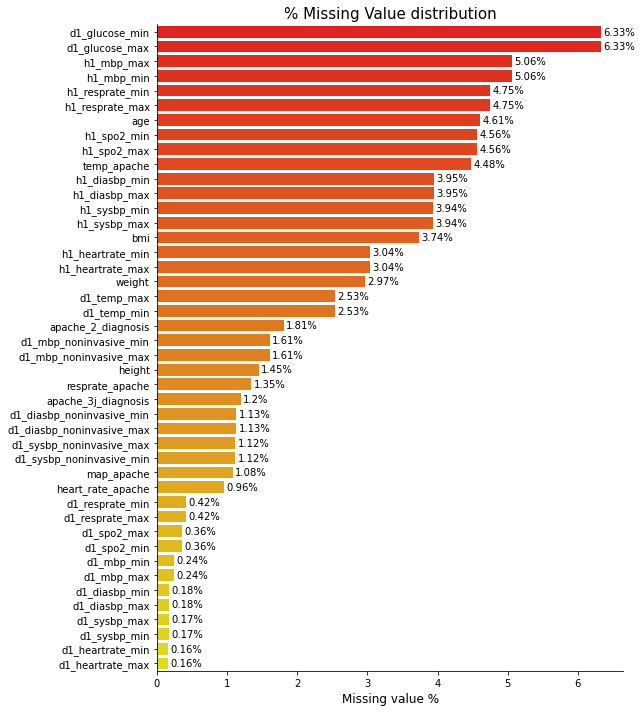

In [28]:
plot_missing(dnum, figsize=(9,10))

In [29]:
# Missing Value Inputation

imputer = IterativeImputer()

for feat in dnum.columns:
    dnum[feat] = imputer.fit_transform(dnum[[feat]])

dnum.isnull().sum()

encounter_id                 0
patient_id                   0
hospital_id                  0
age                          0
bmi                          0
height                       0
icu_id                       0
pre_icu_los_days             0
weight                       0
apache_2_diagnosis           0
apache_3j_diagnosis          0
heart_rate_apache            0
map_apache                   0
resprate_apache              0
temp_apache                  0
d1_diasbp_max                0
d1_diasbp_min                0
d1_diasbp_noninvasive_max    0
d1_diasbp_noninvasive_min    0
d1_heartrate_max             0
d1_heartrate_min             0
d1_mbp_max                   0
d1_mbp_min                   0
d1_mbp_noninvasive_max       0
d1_mbp_noninvasive_min       0
d1_resprate_max              0
d1_resprate_min              0
d1_spo2_max                  0
d1_spo2_min                  0
d1_sysbp_max                 0
d1_sysbp_min                 0
d1_sysbp_noninvasive_max     0
d1_sysbp

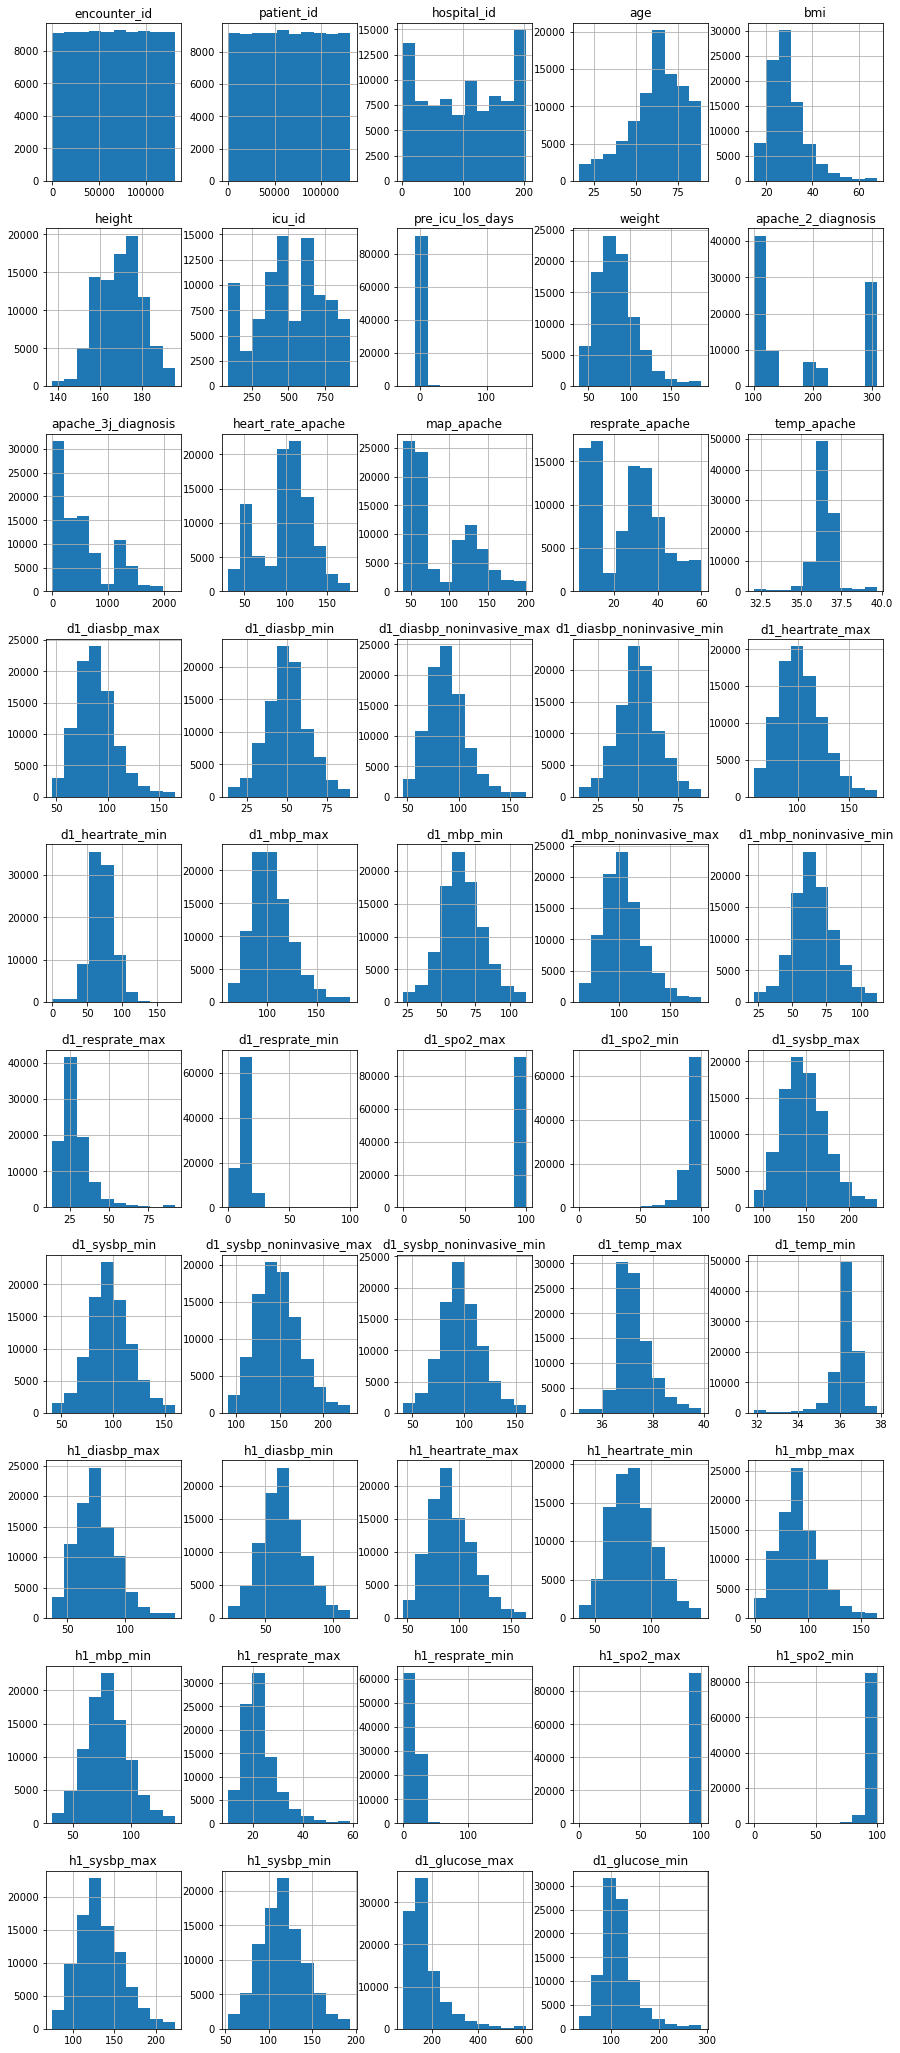

In [30]:
# Observing feature distribution
dnum.hist(layout=(32,5), figsize=(15,120));

In [31]:
# checking right skewed features
right_skewed = [feat for feat in dnum.columns if dnum[feat].skew()>0.7]
right_skewed

['bmi',
 'pre_icu_los_days',
 'weight',
 'apache_3j_diagnosis',
 'map_apache',
 'd1_diasbp_max',
 'd1_diasbp_noninvasive_max',
 'd1_mbp_max',
 'd1_mbp_noninvasive_max',
 'd1_resprate_max',
 'd1_temp_max',
 'h1_diasbp_max',
 'h1_resprate_max',
 'h1_resprate_min',
 'd1_glucose_max',
 'd1_glucose_min']

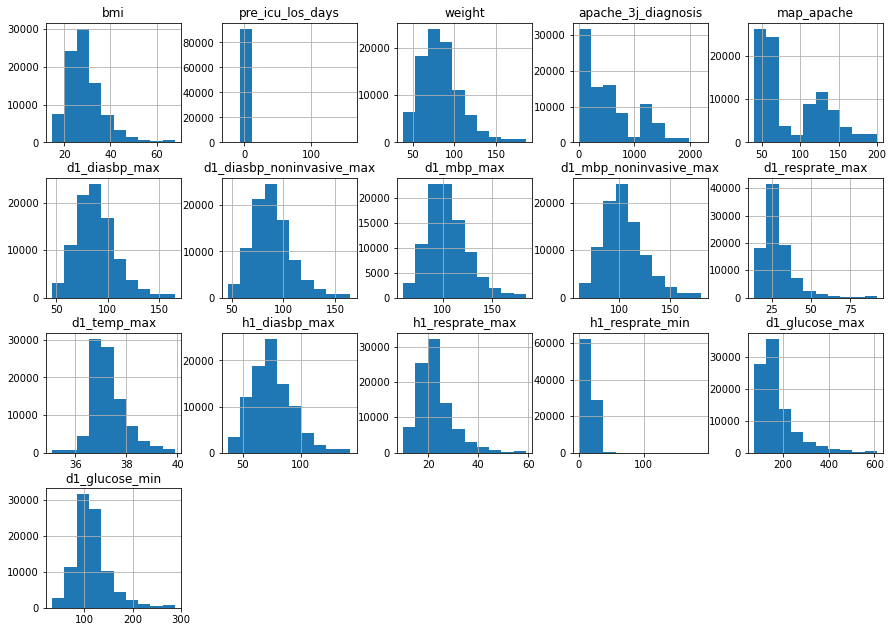

In [32]:
# Observing right skewed features
dnum_right_skewed = dnum[right_skewed]
dnum_right_skewed.hist(layout=(16,5), figsize=(15,45));

In [33]:
# correcting negative values
dnum_right_skewed['pre_icu_los_days'] = np.where(dnum_right_skewed['pre_icu_los_days']<0, abs(dnum_right_skewed['pre_icu_los_days']), dnum_right_skewed['pre_icu_los_days'])

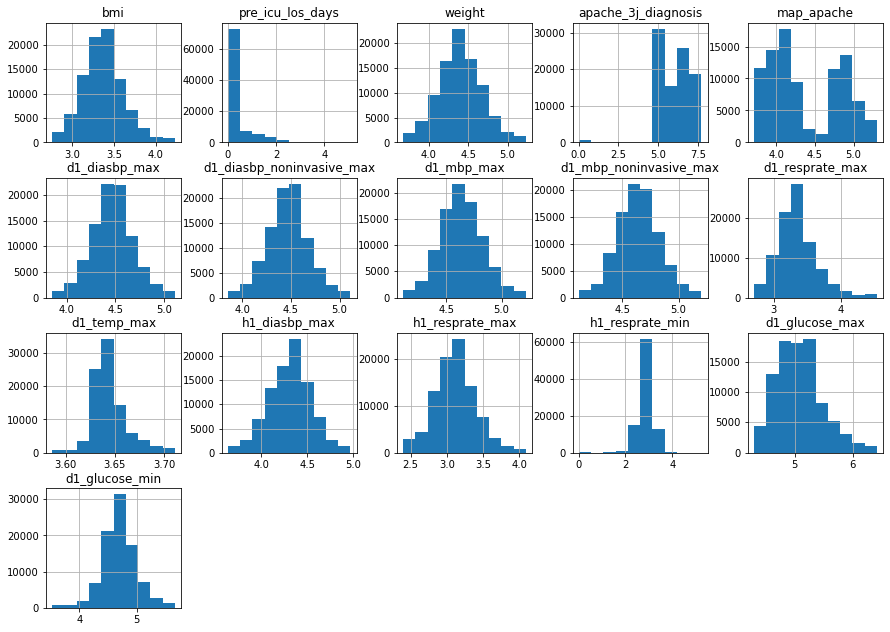

In [34]:
# applying log-transformation on right skewed features
for col in dnum_right_skewed:
    dnum_right_skewed[col] = np.log1p(dnum_right_skewed[col])
    
dnum_right_skewed.hist(layout=(16,5), figsize=(15,45));

In [35]:
# checking left skewed features
left_skewed = [feat for feat in dnum.columns if dnum[feat].skew()<-0.7]
left_skewed

['temp_apache',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_temp_min',
 'h1_spo2_max',
 'h1_spo2_min']

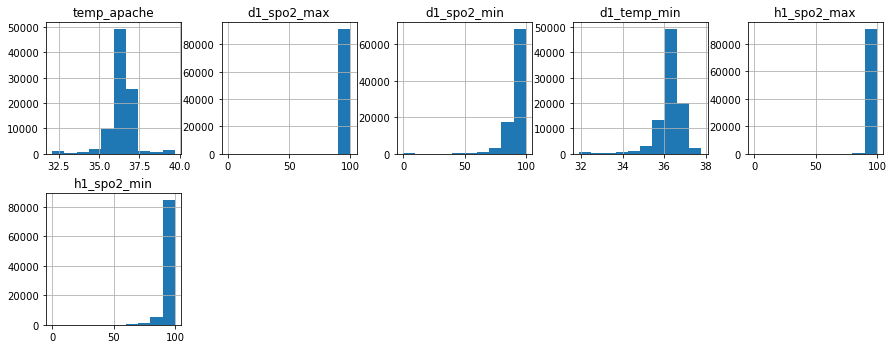

In [36]:
# Observing left skewed features
dnum_left_skewed = dnum[left_skewed]
dnum_left_skewed.hist(layout=(5,5), figsize=(15,15));

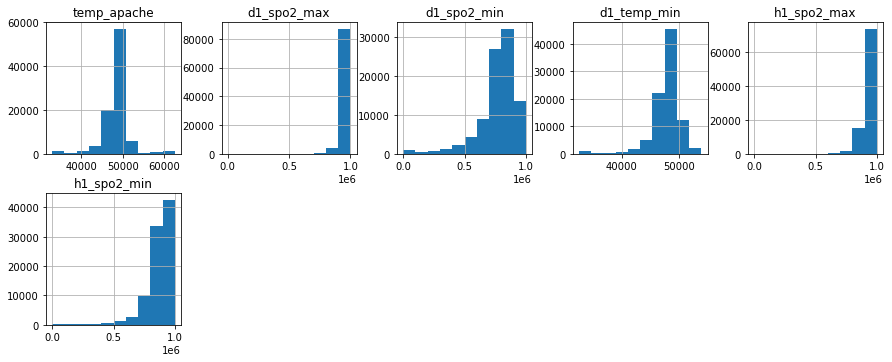

In [37]:
# applying cube transformation on left skewed features
for col in dnum_left_skewed:
    dnum_left_skewed[col] = np.power(dnum_left_skewed[col],3)

dnum_left_skewed.hist(layout=(5,5), figsize=(15,15));

In [38]:
# replacing features in dnum with skewness corrected features
# replacing right skewed features
for col in dnum_right_skewed:
    dnum[col] = dnum_right_skewed[col]
# replacing left skewed features
for col in dnum_left_skewed:
    dnum[col] = dnum_left_skewed[col]

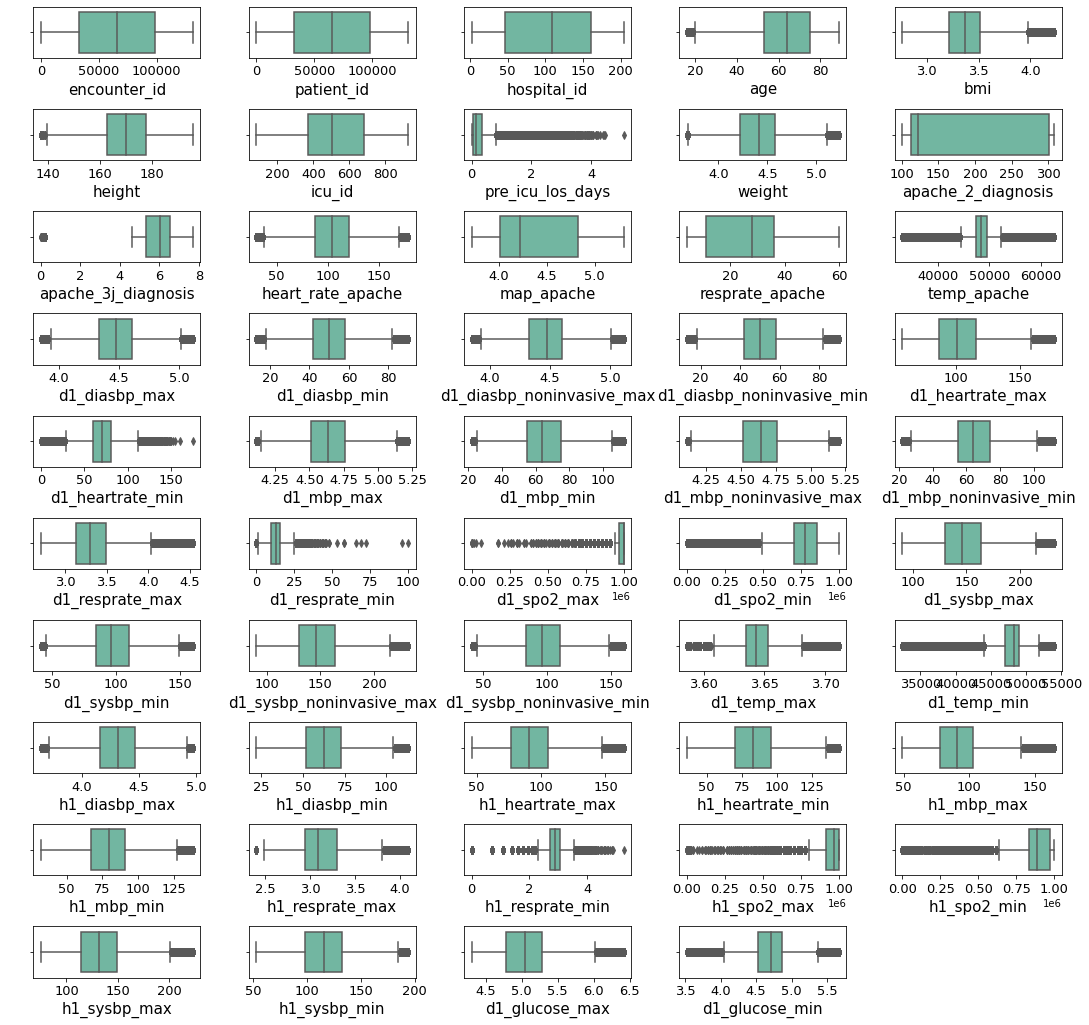

In [39]:
# Visualizing outliers
plt.figure(figsize=(15,45), facecolor='white')
plotnumber = 1

for col in dnum:
    if plotnumber<= len(dnum.columns):
        ax1 = plt.subplot(32, 5, plotnumber)
        sns.boxplot(x=dnum[col], palette='Set2')
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel(col,fontsize=15)
        plt.ylabel(' ',fontsize=15)
    plotnumber+=1
plt.tight_layout()

In [40]:
# Winsorizing
# creating lists for storing values
feats = []
lower = []
upper = []
# extracting values from features
for feat in dnum.columns:
    q1 = dnum[feat].quantile(0.25)
    q3 = dnum[feat].quantile(0.75)
    iqr = q3-q1
    feats.append(feat)
    lower_val = q1 - (1.5*iqr)
    lower.append(lower_val)
    upper_val = q3 + (1.5*iqr)
    upper.append(upper_val)
# saving the values
caps = list(zip(feats, lower, upper))
joblib.dump(caps, 'winsorizer.sav')
# winsorizing features
for item in caps:
    dnum[item[0]] = np.where(dnum[item[0]]<item[1], item[1],
                               np.where(dnum[item[0]]>item[2], item[2], dnum[item[0]]))

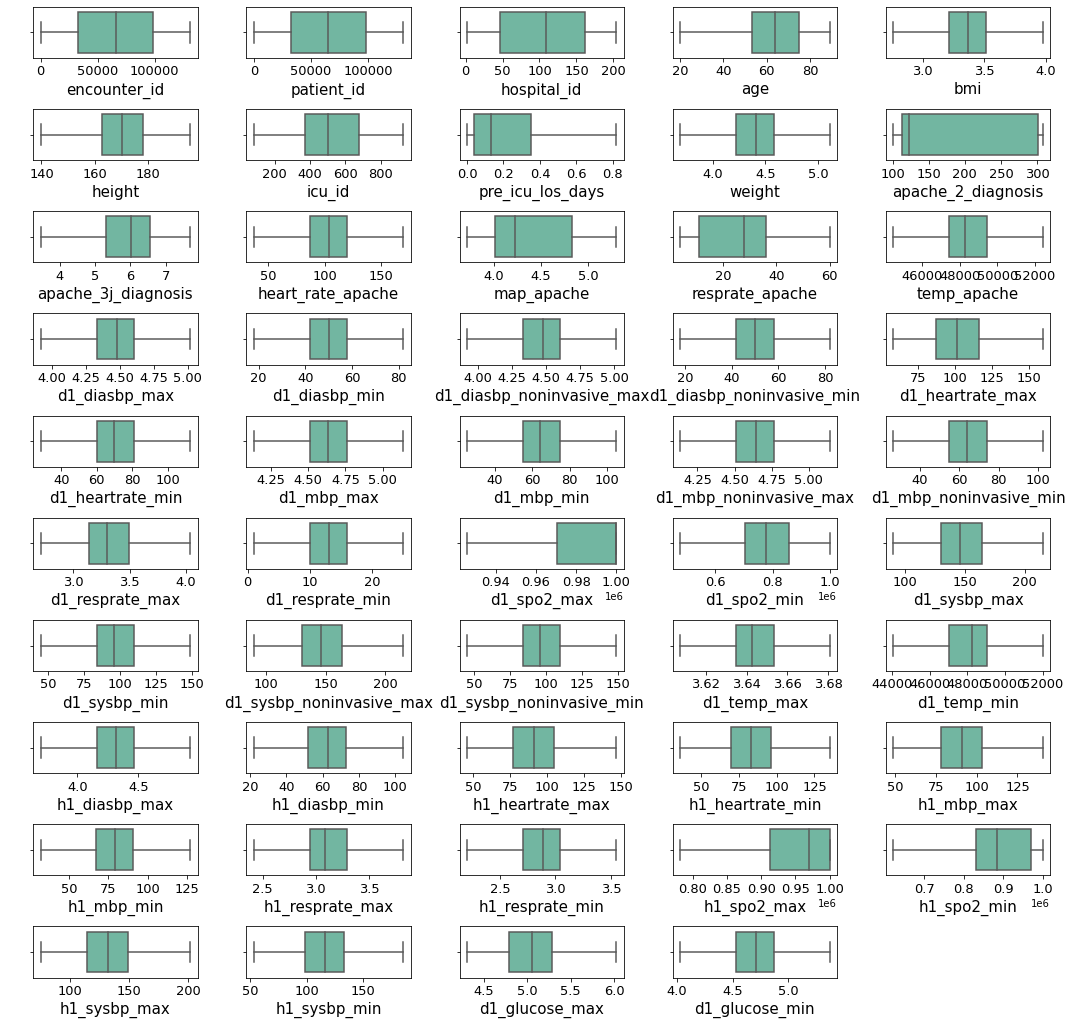

In [41]:
# Visualizing outliers
plt.figure(figsize=(15,45), facecolor='white')
plotnumber = 1

for col in dnum:
    if plotnumber<= len(dnum.columns):
        ax1 = plt.subplot(32, 5, plotnumber)
        sns.boxplot(x=dnum[col], palette='Set2')
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel(col,fontsize=15)
        plt.ylabel(' ',fontsize=15)
    plotnumber+=1
plt.tight_layout()

In [42]:
# checking for missing values
dnum.isnull().sum().sort_values(ascending=False)

encounter_id                 0
d1_resprate_max              0
d1_spo2_max                  0
d1_spo2_min                  0
d1_sysbp_max                 0
d1_sysbp_min                 0
d1_sysbp_noninvasive_max     0
d1_sysbp_noninvasive_min     0
d1_temp_max                  0
d1_temp_min                  0
h1_diasbp_max                0
h1_diasbp_min                0
h1_heartrate_max             0
h1_heartrate_min             0
h1_mbp_max                   0
h1_mbp_min                   0
h1_resprate_max              0
h1_resprate_min              0
h1_spo2_max                  0
h1_spo2_min                  0
h1_sysbp_max                 0
h1_sysbp_min                 0
d1_glucose_max               0
d1_resprate_min              0
d1_mbp_noninvasive_min       0
patient_id                   0
d1_mbp_noninvasive_max       0
hospital_id                  0
age                          0
bmi                          0
height                       0
icu_id                       0
pre_icu_

In [43]:
# droppping 'pre_icu_los_days'
dnum.drop('pre_icu_los_days', axis=1, inplace=True)
dnum.head()

,encounter_id,patient_id,hospital_id,age,bmi,height,icu_id,weight,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_glucose_max,d1_glucose_min
0,66154.0,25312.0,118.0,68.0,3.166740,180.3,92.0,4.316154,113.0,6.220610,118.0,3.713572,36.0,52420.2655,4.234107,37.0,4.234107,37.0,119.0,72.0,4.499810,46.0,4.499810,46.0,3.555348,10.0,1000000.0,476360.0,131.0,73.0,131.0,73.0,3.680704,51478.8480,4.234107,63.0,119.0,108.0,86.0,85.0,3.295837,2.944439,1000000.0,621011.5,131.0,115.0,5.129899,4.700480
1,114252.0,59342.0,81.0,77.0,3.347093,160.0,90.0,4.265493,108.0,5.318169,120.0,3.850148,33.0,44448.5255,4.564348,31.0,4.564348,31.0,118.0,72.0,4.795791,38.0,4.795791,38.0,3.496508,12.0,1000000.0,476360.0,159.0,67.0,159.0,67.0,3.618993,44072.8585,4.127134,48.0,114.0,100.0,85.0,57.0,3.465736,3.367296,857375.0,621011.5,95.0,71.0,4.983607,4.859812
2,119783.0,50777.0,118.0,25.0,3.494991,172.7,93.0,4.567468,122.0,6.556821,102.0,4.234107,37.0,49430.8630,4.488636,48.0,4.488636,48.0,96.0,68.0,4.634729,68.0,4.634729,68.0,3.091042,8.0,941192.0,753571.0,148.0,105.0,148.0,105.0,3.637586,49430.8630,4.488636,58.0,96.0,78.0,91.0,83.0,3.044522,2.833213,941192.0,753571.0,148.0,124.0,5.168425,4.748239
3,79267.0,46918.0,118.0,81.0,3.162940,165.1,92.0,4.138361,203.0,7.095918,114.0,4.110874,4.0,44448.5255,3.919078,42.0,3.919078,42.0,116.0,92.0,4.442651,84.0,4.442651,84.0,3.178054,7.0,1000000.0,857375.0,158.0,84.0,158.0,84.0,3.663562,44072.8585,4.143135,44.0,100.0,96.0,92.0,71.0,2.564949,2.484907,1000000.0,970299.0,136.0,106.0,5.225747,4.488636
4,92056.0,34377.0,33.0,20.0,3.407372,188.0,91.0,4.442985,119.0,6.400274,60.0,4.644391,16.0,49430.8630,4.605170,57.0,4.605170,57.0,89.0,60.0,4.653960,90.0,4.653960,90.0,2.944439,16.0,1000000.0,884736.0,147.0,120.0,147.0,120.0,3.642836,49430.8630,4.605170,68.0,89.0,76.0,104.0,92.0,3.162670,2.902055,1000000.0,1000000.0,130.0,120.0,5.168425,4.748239


### Categorical Features

In [44]:
dcat.describe()

,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,90318,91688,91601,91713,91713,90051,90051,91713,91713,91713,90998.0,89812.0,89812.0,90676.0,89812.0,90998.0,90998.0,90998.0,90998.0,90998.0,90998.0,90998.0,90998.0,90998.0,90998.0
unique,6,2,5,3,8,11,10,2,2,2,2.0,4.0,6.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
top,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Cardiovascular,Cardiovascular,0,0,0,0.0,4.0,6.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,70684,49469,54060,86183,50586,29999,38816,83798,74862,73269,88452.0,62995.0,70960.0,89812.0,56909.0,77237.0,61358.0,90920.0,89570.0,70506.0,89816.0,88617.0,90355.0,90622.0,89120.0


In [45]:
dcat.shape

(91713, 25)

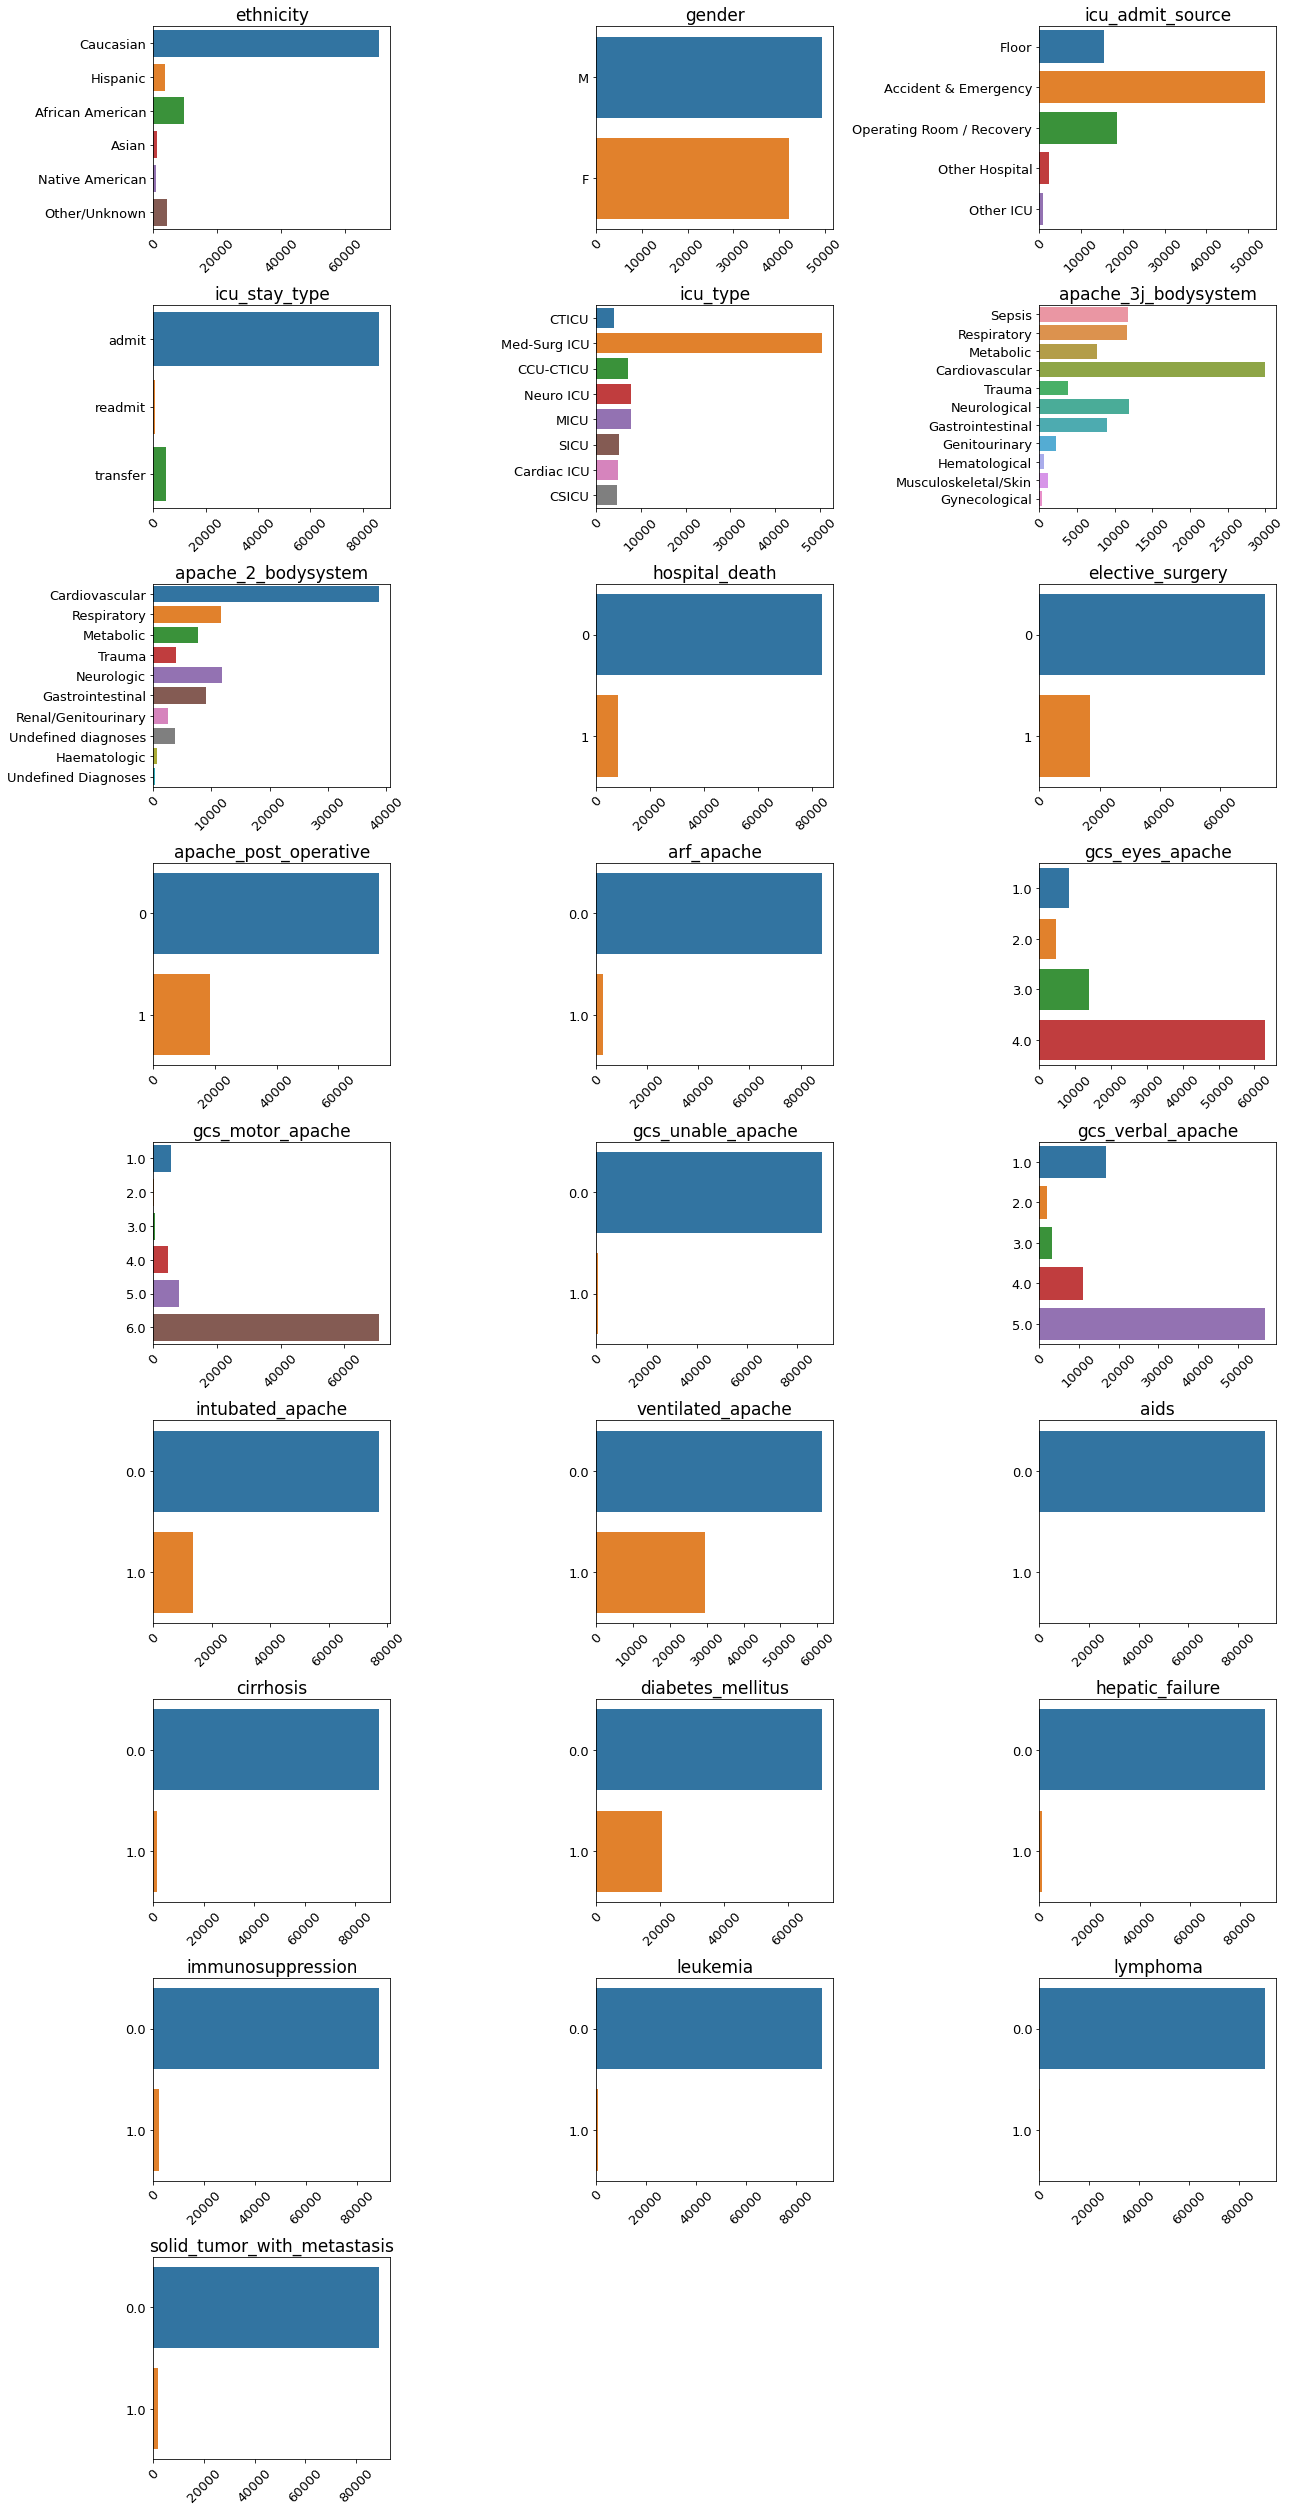

In [46]:
# Plotting Categorical features composition
plt.figure(figsize=(18,35))
plotnumber = 1

for col in dcat:
    if plotnumber <= 25:
        ax1 = plt.subplot(9,3,plotnumber)
        sns.countplot(data=dcat, y=col)
        plt.xticks(fontsize=13, rotation=45)
        plt.yticks(fontsize=13)
        plt.title(f"{col}", fontsize=17)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

In [47]:
# function for checking imbalanced features
def check_imbalanced(df, threshold=0.95):
    imbalanced_feats = []
    for col in df:
        if df[col].value_counts().values.max()/df.shape[0]>threshold:
            imbalanced_feats.append(col)
    return imbalanced_feats

In [48]:
imbalanced_features = check_imbalanced(dcat)

In [49]:
# dropping highly imbalanced features
dcat.drop(columns=imbalanced_features, inplace=True)

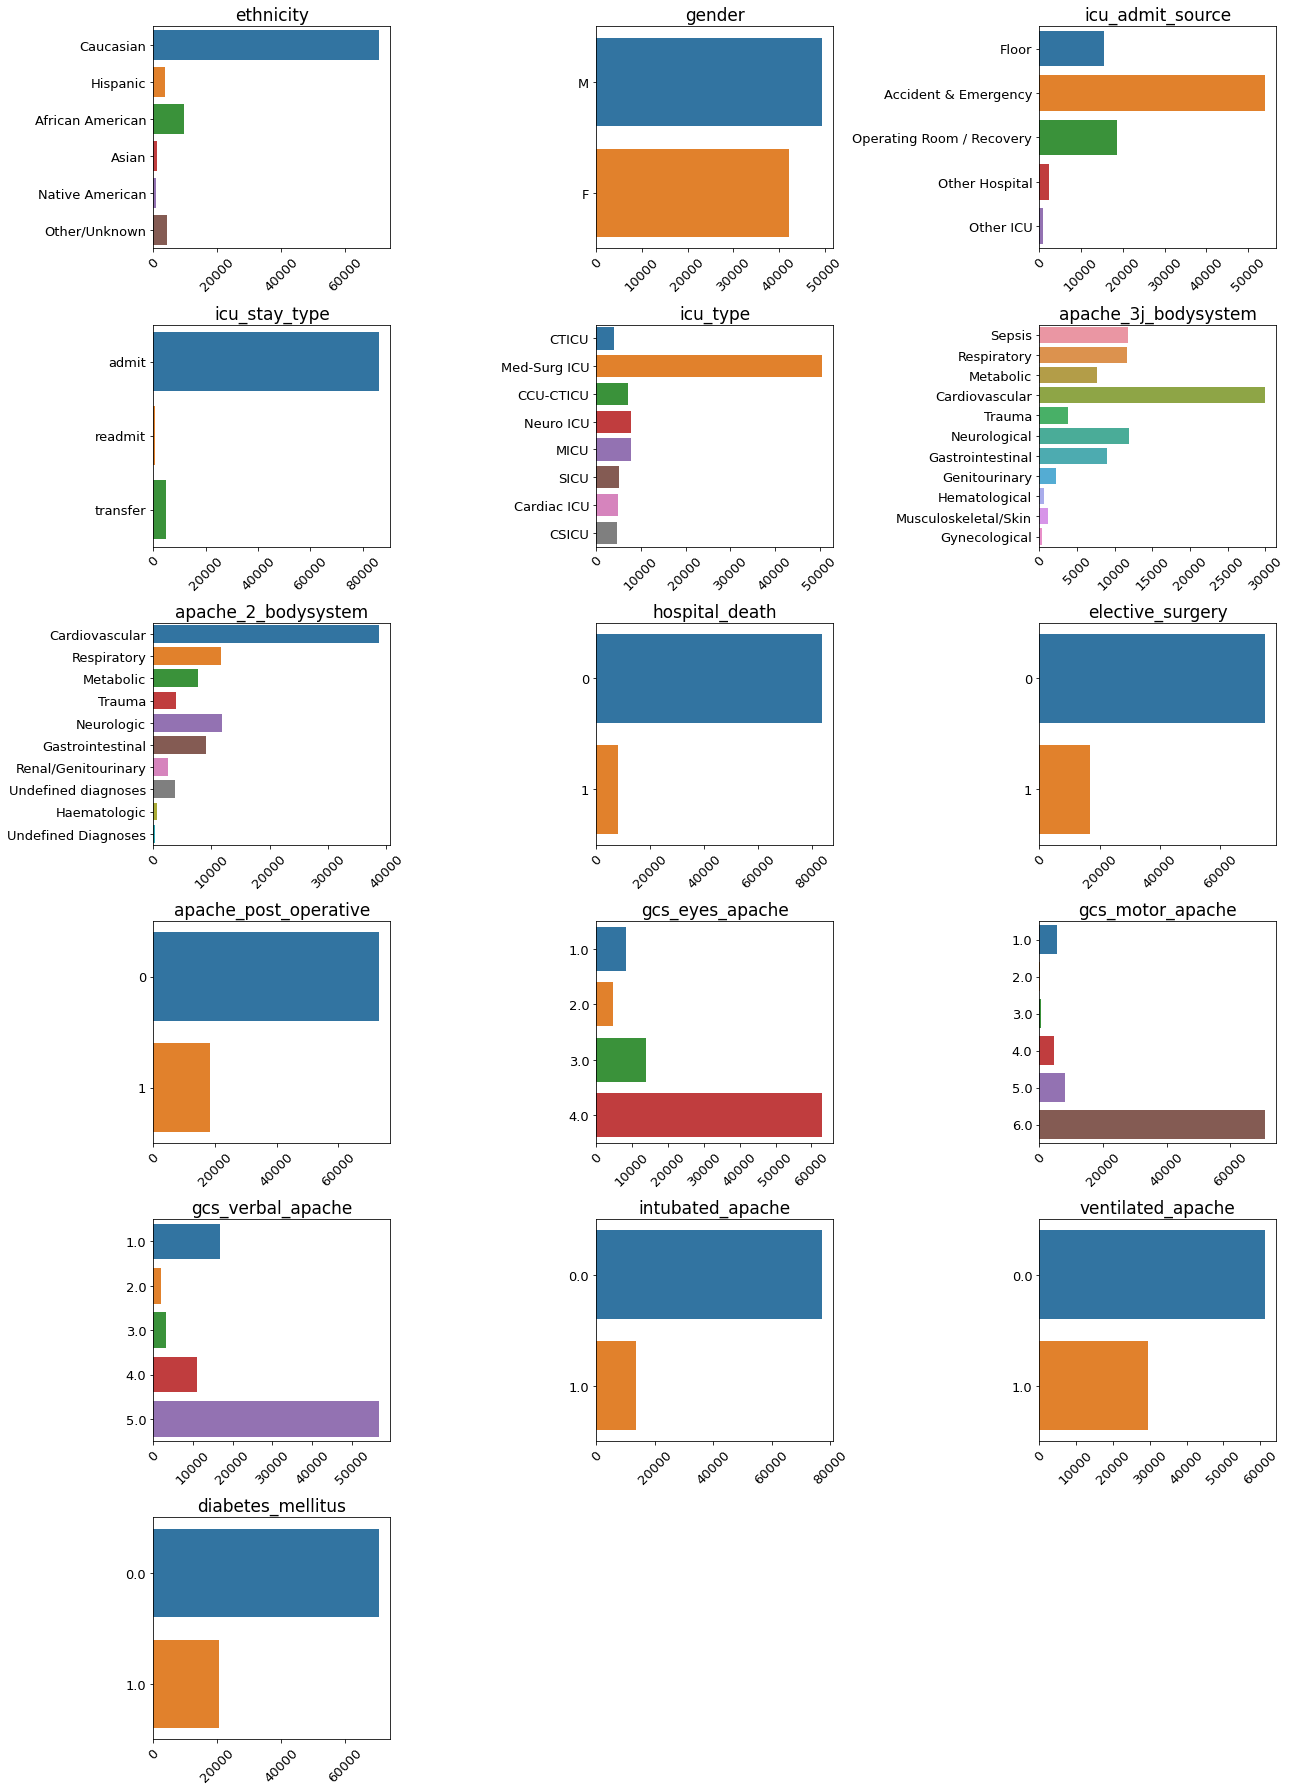

In [50]:
# Plotting Categorical features composition
plt.figure(figsize=(18,25))
plotnumber = 1

for col in dcat:
    if plotnumber <= 16:
        ax1 = plt.subplot(6,3,plotnumber)
        sns.countplot(data=dcat, y=col)
        plt.xticks(fontsize=13, rotation=45)
        plt.yticks(fontsize=13)
        plt.title(f"{col}", fontsize=17)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

In [51]:
# binarizing ethnicity
def binarize_ethnicity(df):
    df['ethnicity'] = np.where(df['ethnicity']=='Caucasian', 1, 0)
    return df

dcat = binarize_ethnicity(dcat)

In [52]:
# grouping icu_admit_source
def group_icu_admit_source(df):
    df['icu_admit_source'] = np.where(df['icu_admit_source']=='Accident & Emergency', 'Emergency',
                                      np.where(df['icu_admit_source']=='Other Hospital', 'Other',
                                               np.where(df['icu_admit_source']=='Other ICU', 'Other', df['icu_admit_source'])))
    return df

dcat = group_icu_admit_source(dcat)

In [53]:
# grouping icu_stay_type
def group_icu_stay_type(df):
    df['icu_stay_type'] = np.where(df['icu_stay_type']=='admit', 1, 0)
    return df

dcat = group_icu_stay_type(dcat)

In [54]:
# grouping gender
def group_gender(df):
    df['gender'] = np.where(df['gender']=='M', 1, 0)
    return df

dcat = group_gender(dcat)

In [55]:
# grouping apache_2_bodysystem
def group_apache_2_bodysystem(df):
    df['apache_2_bodysystem'] = np.where(df['apache_2_bodysystem']=='Undefined diagnoses', 'Undefined',
                                         np.where(df['apache_2_bodysystem']=='Undefined Diagnoses', 'Undefined',df['apache_2_bodysystem']))
    return df

dcat = group_apache_2_bodysystem(dcat)

In [56]:
# defining a function for frequency encoding
def frequency_encoding(df,feats):
    for feat in feats:
        indx = (df.groupby(feat).size()/df.shape[0]).index
        vals = (df.groupby(feat).size()/df.shape[0]).values
        maps = dict()
        for i,v in list(zip(indx,vals)):
            maps[i]=v
        df[feat] = df[feat].map(maps)
    return df

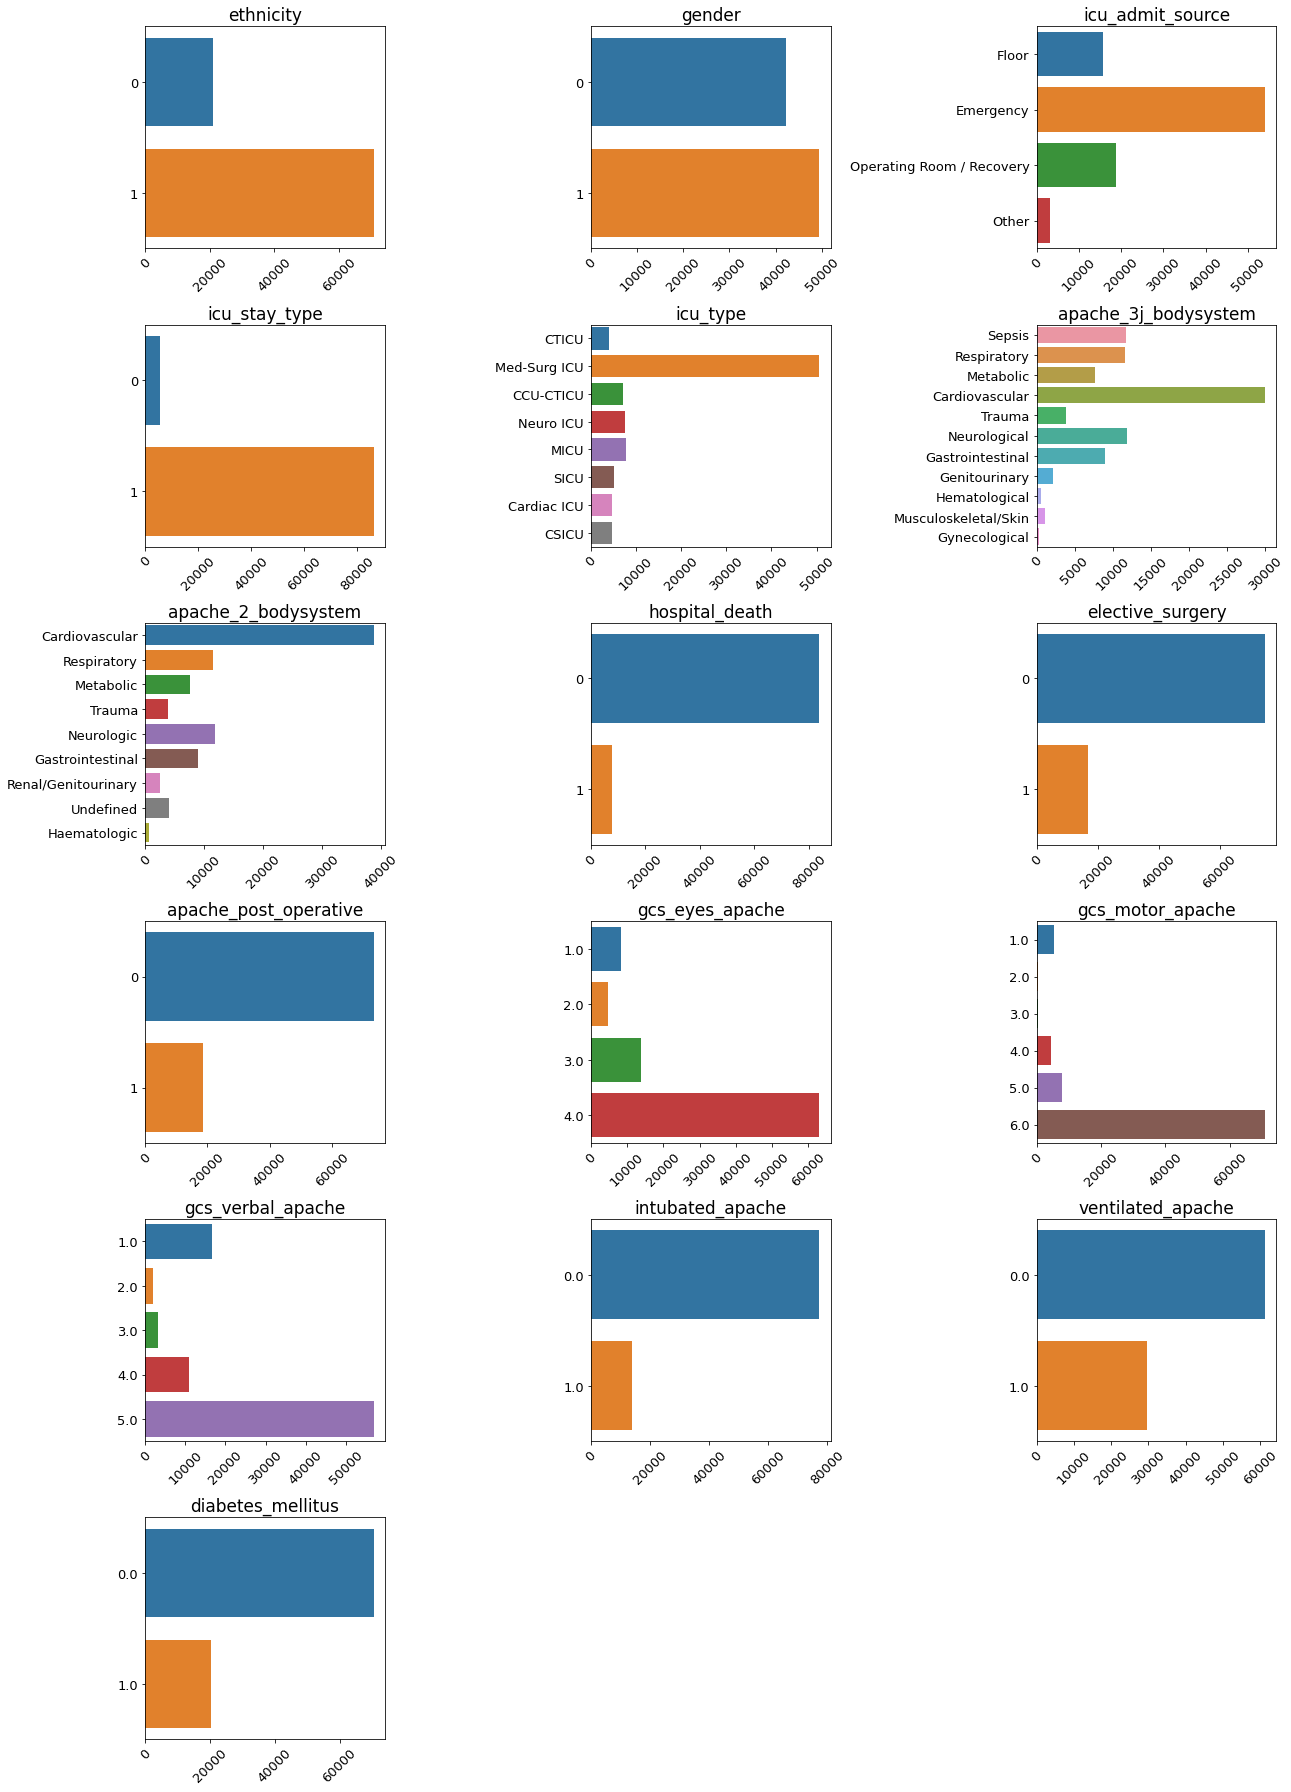

In [57]:
# Plotting Categorical features composition
plt.figure(figsize=(18,25))
plotnumber = 1

for col in dcat:
    if plotnumber <= 16:
        ax1 = plt.subplot(6,3,plotnumber)
        sns.countplot(data=dcat, y=col)
        plt.xticks(fontsize=13, rotation=45)
        plt.yticks(fontsize=13)
        plt.title(f"{col}", fontsize=17)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

In [58]:
freq_enc_feats = ['icu_admit_source', 'icu_type','apache_3j_bodysystem', 'apache_2_bodysystem']
dcat = frequency_encoding(dcat, freq_enc_feats)

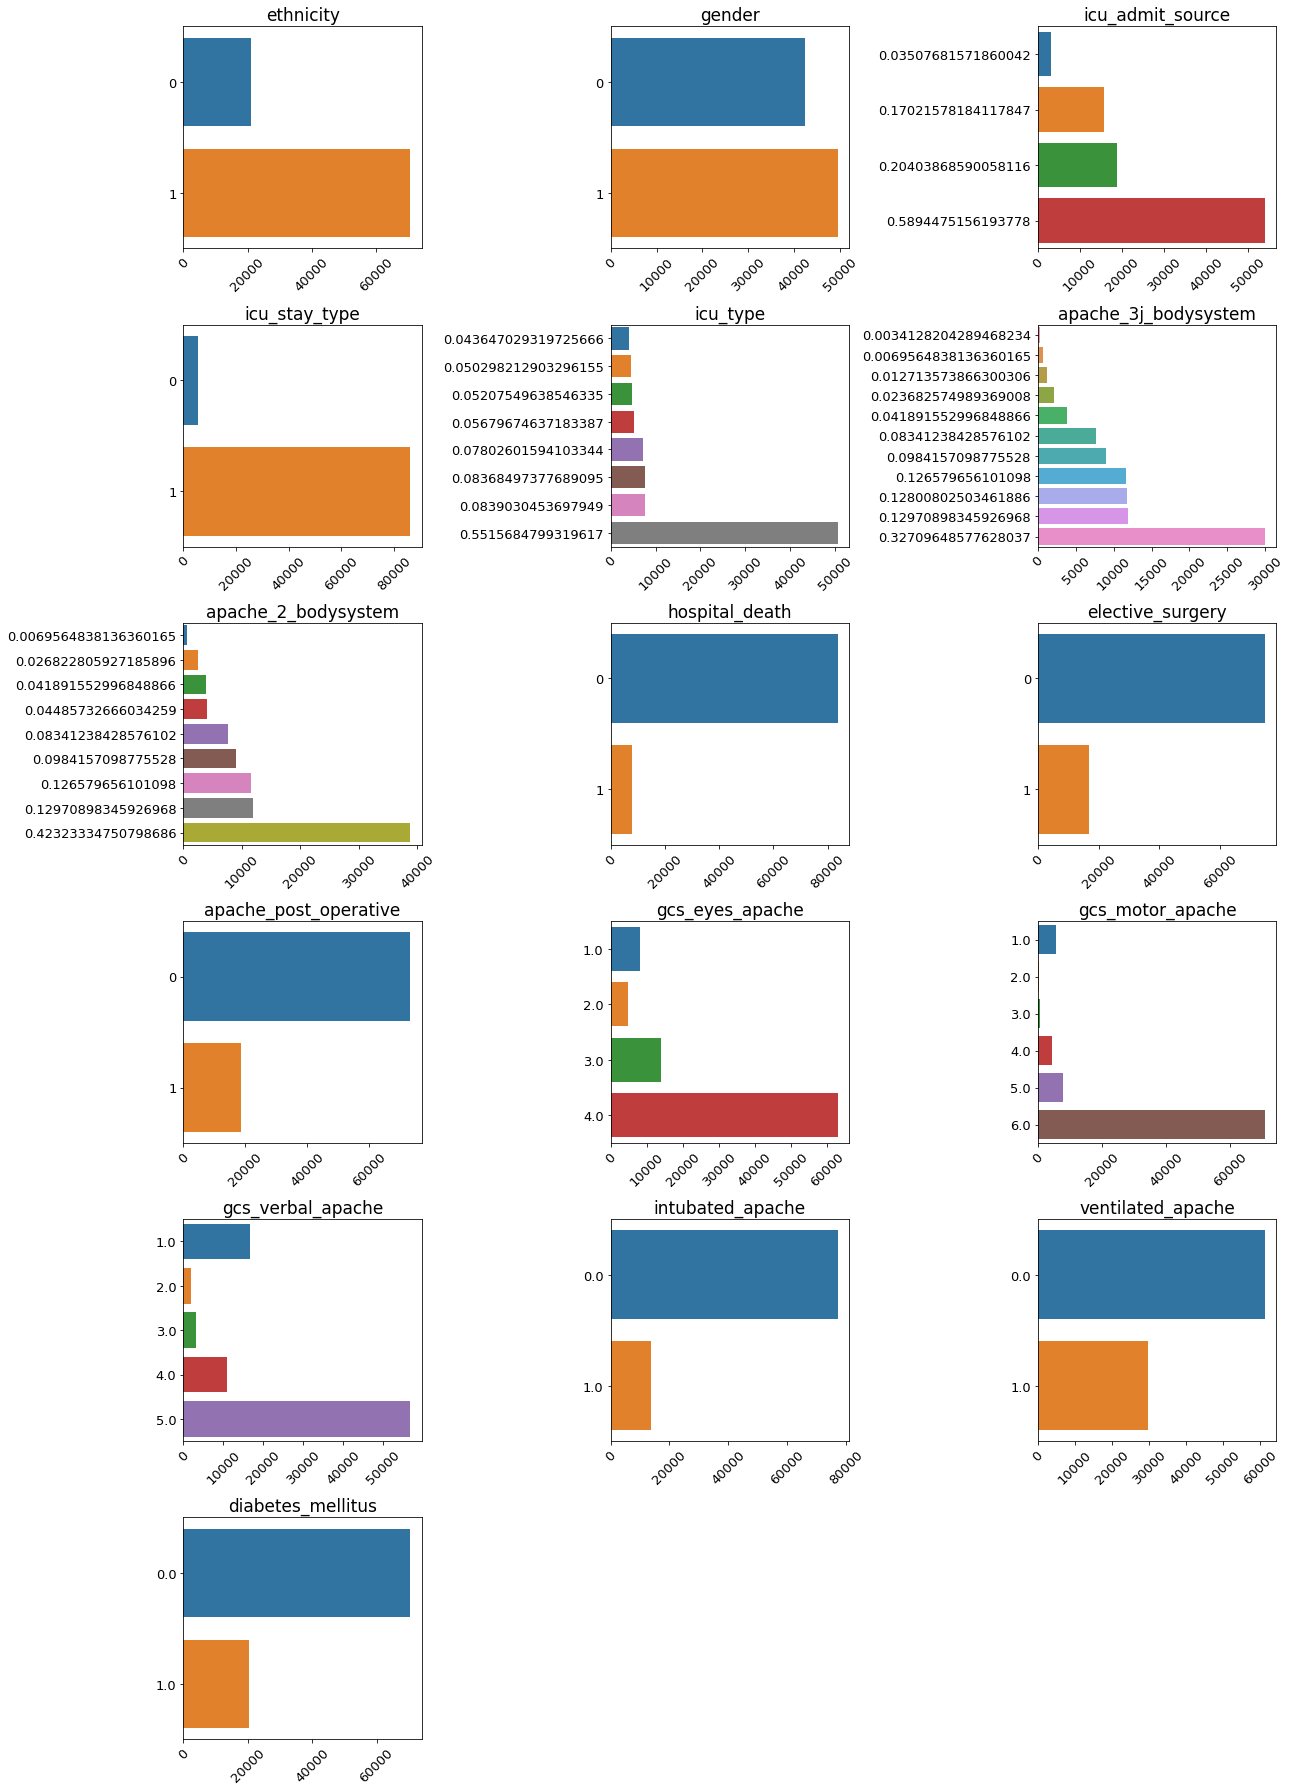

In [59]:
# Plotting Categorical features composition
plt.figure(figsize=(18,25))
plotnumber = 1

for col in dcat:
    if plotnumber <= 16:
        ax1 = plt.subplot(6,3,plotnumber)
        sns.countplot(data=dcat, y=col)
        plt.xticks(fontsize=13, rotation=45)
        plt.yticks(fontsize=13)
        plt.title(f"{col}", fontsize=17)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

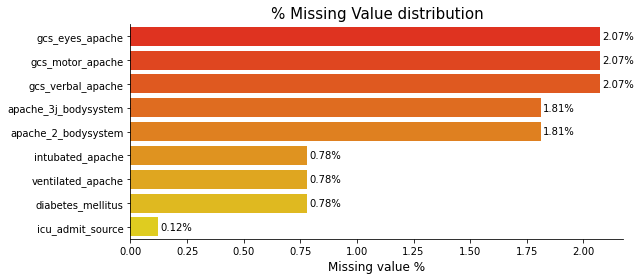

In [60]:
plot_missing(dcat, figsize=(9,4))

In [61]:
# using mode for imputation
def mode_impute(df):
    missing_cat_feats = df.columns[df.isnull().any()]

    for feat in missing_cat_feats:
        mode = df[feat].mode()[0]
        df[feat].fillna(mode, inplace=True)
    return df

In [62]:
dcat = mode_impute(dcat)

In [63]:
dcat.isnull().sum().sum()

0

In [64]:
# Concatenating dnum and dcat
dnum = dnum.reset_index(drop=True)
dcat = dcat.reset_index(drop=True)
df = pd.concat([dnum, dcat], axis=1)
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,height,icu_id,weight,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_glucose_max,d1_glucose_min,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,hospital_death,elective_surgery,apache_post_operative,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,diabetes_mellitus
0,66154.0,25312.0,118.0,68.0,3.166740,180.3,92.0,4.316154,113.0,6.220610,118.0,3.713572,36.0,52420.2655,4.234107,37.0,4.234107,37.0,119.0,72.0,4.499810,46.0,4.499810,46.0,3.555348,10.0,1000000.0,476360.0,131.0,73.0,131.0,73.0,3.680704,51478.8480,4.234107,63.0,119.0,108.0,86.0,85.0,3.295837,2.944439,1000000.0,621011.5,131.0,115.0,5.129899,4.700480,1,1,0.170216,1,0.043647,0.128008,0.423233,0,0,0,3.0,6.0,4.0,0.0,0.0,1.0
1,114252.0,59342.0,81.0,77.0,3.347093,160.0,90.0,4.265493,108.0,5.318169,120.0,3.850148,33.0,44448.5255,4.564348,31.0,4.564348,31.0,118.0,72.0,4.795791,38.0,4.795791,38.0,3.496508,12.0,1000000.0,476360.0,159.0,67.0,159.0,67.0,3.618993,44072.8585,4.127134,48.0,114.0,100.0,85.0,57.0,3.465736,3.367296,857375.0,621011.5,95.0,71.0,4.983607,4.859812,1,0,0.170216,1,0.551568,0.126580,0.126580,0,0,0,1.0,3.0,1.0,0.0,1.0,1.0
2,119783.0,50777.0,118.0,25.0,3.494991,172.7,93.0,4.567468,122.0,6.556821,102.0,4.234107,37.0,49430.8630,4.488636,48.0,4.488636,48.0,96.0,68.0,4.634729,68.0,4.634729,68.0,3.091042,8.0,941192.0,753571.0,148.0,105.0,148.0,105.0,3.637586,49430.8630,4.488636,58.0,96.0,78.0,91.0,83.0,3.044522,2.833213,941192.0,753571.0,148.0,124.0,5.168425,4.748239,1,0,0.589448,1,0.551568,0.083412,0.083412,0,0,0,3.0,6.0,5.0,0.0,0.0,0.0
3,79267.0,46918.0,118.0,81.0,3.162940,165.1,92.0,4.138361,203.0,7.095918,114.0,4.110874,4.0,44448.5255,3.919078,42.0,3.919078,42.0,116.0,92.0,4.442651,84.0,4.442651,84.0,3.178054,7.0,1000000.0,857375.0,158.0,84.0,158.0,84.0,3.663562,44072.8585,4.143135,44.0,100.0,96.0,92.0,71.0,2.564949,2.484907,1000000.0,970299.0,136.0,106.0,5.225747,4.488636,1,0,0.204039,1,0.043647,0.327096,0.423233,0,1,1,4.0,6.0,5.0,1.0,1.0,0.0
4,92056.0,34377.0,33.0,20.0,3.407372,188.0,91.0,4.442985,119.0,6.400274,60.0,4.644391,16.0,49430.8630,4.605170,57.0,4.605170,57.0,89.0,60.0,4.653960,90.0,4.653960,90.0,2.944439,16.0,1000000.0,884736.0,147.0,120.0,147.0,120.0,3.642836,49430.8630,4.605170,68.0,89.0,76.0,104.0,92.0,3.162670,2.902055,1000000.0,1000000.0,130.0,120.0,5.168425,4.748239,1,1,0.589448,1,0.551568,0.041892,0.041892,0,0,0,4.0,6.0,5.0,0.0,0.0,0.0


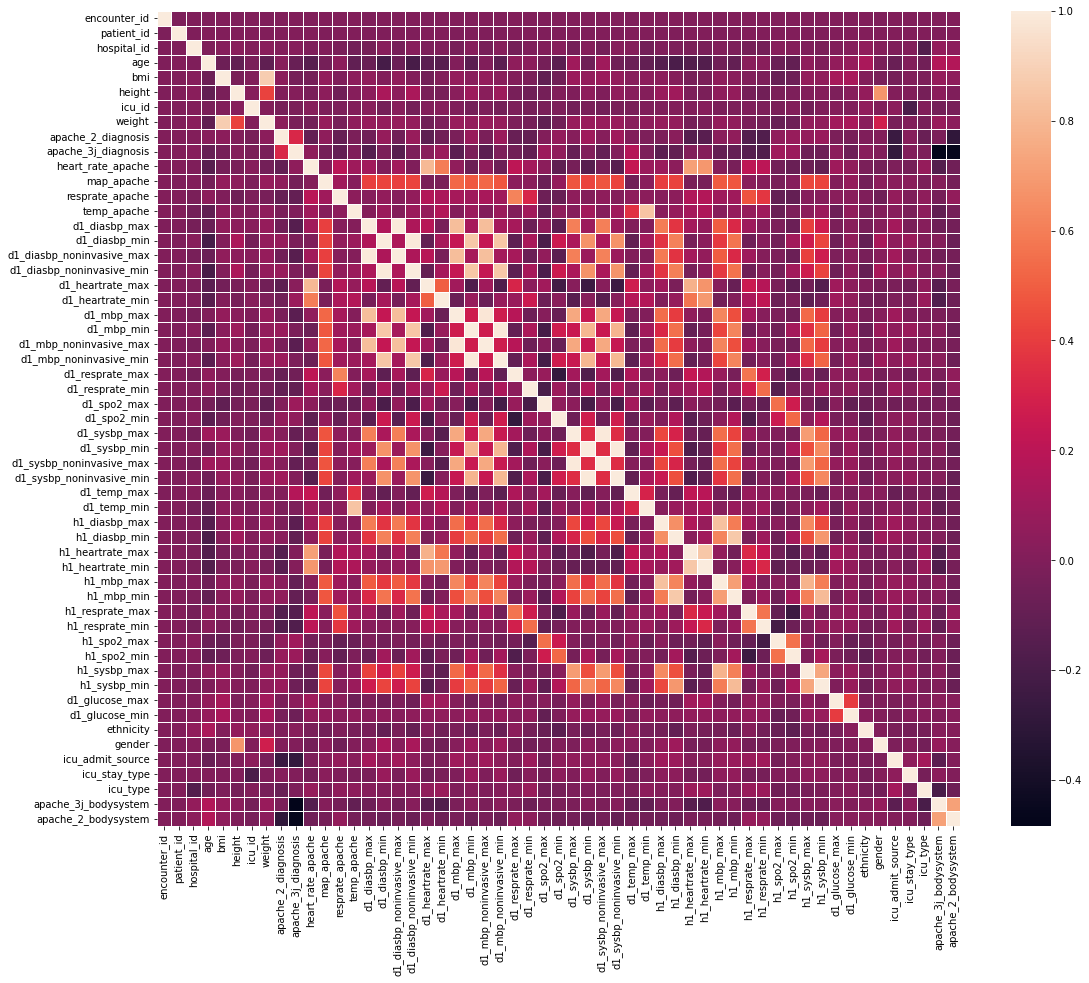

In [65]:
# Correlation plot
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(), linewidths=1)
plt.show()

In [66]:
# dropping 'height' and 'weight'
df.drop(columns=['height', 'weight'], inplace=True)

In [67]:
# creating a new feature 'd1_temp_range' and dropping 'd1_temp_max' and 'd1_temp_min'
df['d1_temp_range'] = np.abs(df['d1_temp_max'] - df['d1_temp_min'])
df.drop(columns=['d1_temp_max', 'd1_temp_min'], inplace=True)

In [68]:
# creating a new feature 'd1_spo2_range' and dropping 'd1_spo2_max' and 'd1_spo2_min'
df['d1_spo2_range'] = np.abs(df['d1_spo2_max'] - df['d1_spo2_min'])
df.drop(columns=['d1_spo2_max', 'd1_spo2_min'], inplace=True)

In [69]:
# creating a new feature 'h1_spo2_range' and dropping 'h1_spo2_max' and 'h1_spo2_min'
df['h1_spo2_range'] = np.abs(df['h1_spo2_max'] - df['h1_spo2_min'])
df.drop(columns=['h1_spo2_max', 'h1_spo2_min'], inplace=True)

In [70]:
# creating a new feature 'd1_resprate_range' and dropping 'd1_resprate_max' and 'd1_resprate_min'
df['d1_resprate_range'] = np.abs(df['d1_resprate_max'] - df['d1_resprate_min'])
df.drop(columns=['d1_resprate_max', 'd1_resprate_min'], inplace=True)

In [71]:
# creating a new feature 'h1_resprate_range' and dropping 'h1_resprate_max' and 'h1_resprate_min'
df['h1_resprate_range'] = np.abs(df['h1_resprate_max'] - df['h1_resprate_min'])
df.drop(columns=['h1_resprate_max', 'h1_resprate_min'], inplace=True)

In [72]:
# creating a new feature 'h1_heartrate_range' and dropping 'h1_heartrate_max' and 'h1_heartrate_min'
df['h1_heartrate_range'] = np.abs(df['h1_heartrate_max'] - df['h1_heartrate_min'])
df.drop(columns=['h1_heartrate_max', 'h1_heartrate_min'], inplace=True)

In [73]:
# creating a new feature 'd1_heartrate_range' and dropping 'd1_heartrate_max' and 'd1_heartrate_min'
df['d1_heartrate_range'] = np.abs(df['d1_heartrate_max'] - df['d1_heartrate_min'])
df.drop(columns=['d1_heartrate_max', 'd1_heartrate_min'], inplace=True)

In [74]:
# creating a new feature 'h1_mbp_range' and dropping 'h1_mbp_max' and 'h1_mbp_min'
df['h1_mbp_range'] = np.abs(df['h1_mbp_max'] - df['h1_mbp_min'])
df.drop(columns=['h1_mbp_max', 'h1_mbp_min'], inplace=True)

In [75]:
# creating a new feature 'd1_mbp_range' and dropping 'd1_mbp_max' and 'd1_mbp_min'
df['d1_mbp_range'] = np.abs(df['d1_mbp_max'] - df['d1_mbp_min'])
df.drop(columns=['d1_mbp_max', 'd1_mbp_min'], inplace=True)

In [76]:
# creating a new feature 'd1_mbp_noninvasive_range' and dropping 'd1_mbp_noninvasive_max' and 'd1_mbp_noninvasive_min'
df['d1_mbp_noninvasive_range'] = np.abs(df['d1_mbp_noninvasive_max'] - df['d1_mbp_noninvasive_min'])
df.drop(columns=['d1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min'], inplace=True)

In [77]:
# creating a new feature 'd1_sysbp_range' and dropping 'd1_sysbp_max' and 'd1_sysbp_min'
df['d1_sysbp_range'] = np.abs(df['d1_sysbp_max'] - df['d1_sysbp_min'])
df.drop(columns=['d1_sysbp_max', 'd1_sysbp_min'], inplace=True)

In [78]:
# creating a new feature 'h1_sysbp_range' and dropping 'h1_sysbp_max' and 'h1_sysbp_min'
df['h1_sysbp_range'] = np.abs(df['h1_sysbp_max'] - df['h1_sysbp_min'])
df.drop(columns=['h1_sysbp_max', 'h1_sysbp_min'], inplace=True)

In [79]:
# creating a new feature 'd1_diasbp_range' and dropping 'd1_diasbp_max' and 'd1_diasbp_min'
df['d1_diasbp_range'] = np.abs(df['d1_diasbp_max'] - df['d1_diasbp_min'])
df.drop(columns=['d1_diasbp_max', 'd1_diasbp_min'], inplace=True)

In [80]:
# creating a new feature 'h1_diasbp_range' and dropping 'h1_diasbp_max' and 'h1_diasbp_min'
df['h1_diasbp_range'] = np.abs(df['h1_diasbp_max'] - df['h1_diasbp_min'])
df.drop(columns=['h1_diasbp_max', 'h1_diasbp_min'], inplace=True)

In [81]:
# creating a new feature 'd1_sysbp_noninvasive_range' and dropping 'd1_sysbp_noninvasive_max' and 'd1_sysbp_noninvasive_min'
df['d1_sysbp_noninvasive_range'] = np.abs(df['d1_sysbp_noninvasive_max'] - df['d1_sysbp_noninvasive_min'])
df.drop(columns=['d1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min'], inplace=True)

In [82]:
# creating a new feature 'd1_diasbp_noninvasive_range' and dropping 'd1_diasbp_noninvasive_max' and 'd1_diasbp_noninvasive_min'
df['d1_diasbp_noninvasive_range'] = np.abs(df['d1_diasbp_noninvasive_max'] - df['d1_diasbp_noninvasive_min'])
df.drop(columns=['d1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min'], inplace=True)

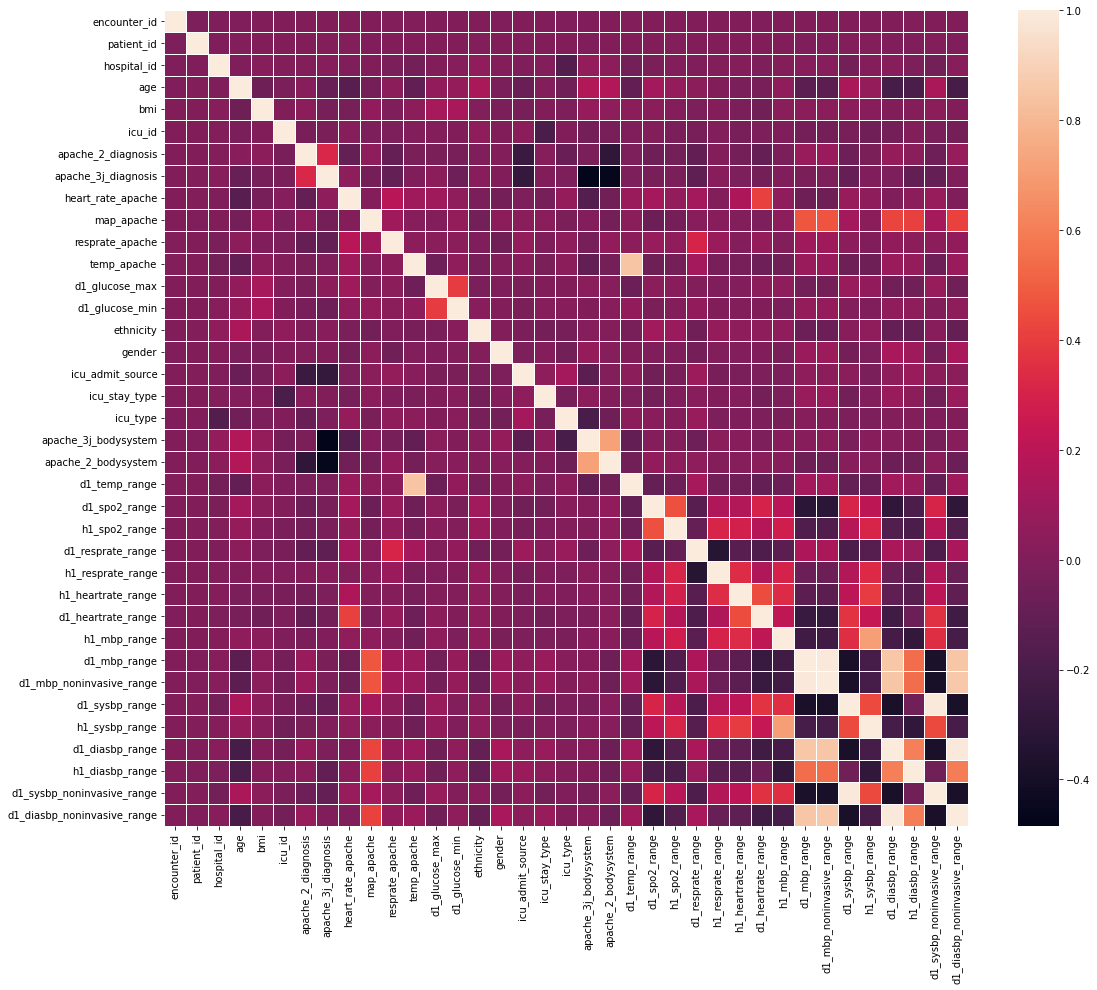

In [83]:
# Correlation plot
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(), linewidths=1)
plt.show()

In [84]:
# creating a new feature 'd1_sysbp_total_range' and dropping 'd1_sysbp_noninvasive_range' and 'd1_sysbp_range'
df['d1_sysbp_total_range'] = 2 * df['d1_sysbp_noninvasive_range'] * df['d1_sysbp_range']/(df['d1_sysbp_noninvasive_range'] + df['d1_sysbp_range'] + 0.00001)
df.drop(columns=['d1_sysbp_noninvasive_range', 'd1_sysbp_range'], inplace=True)

In [85]:
# creating a new feature 'd1_mbp_total_range' and dropping 'd1_mbp_noninvasive_range' and 'd1_mbp_range'
df['d1_mbp_total_range'] = 2 * df['d1_mbp_noninvasive_range'] * df['d1_mbp_range']/(df['d1_mbp_noninvasive_range'] + df['d1_mbp_range'] + 0.00001)
df.drop(columns=['d1_mbp_noninvasive_range', 'd1_mbp_range'], inplace=True)

In [86]:
# creating a new feature 'd1_diasbp_total_range' and dropping 'd1_diasbp_noninvasive_range' and 'd1_diasbp_range'
df['d1_diasbp_total_range'] = 2 * df['d1_diasbp_noninvasive_range'] * df['d1_diasbp_range']/(df['d1_diasbp_noninvasive_range'] + df['d1_diasbp_range'] + 0.00001)
df.drop(columns=['d1_diasbp_noninvasive_range', 'd1_diasbp_range'], inplace=True)

In [87]:
# creating a new feature 'h1_mbp_sysbp_range' and dropping 'h1_mbp_range' and 'h1_sysbp_range'
df['h1_mbp_sysbp_range'] = 2 * df['h1_mbp_range'] * df['h1_sysbp_range']/(df['h1_mbp_range'] + df['h1_sysbp_range'] + 0.00001)
df.drop(columns=['h1_mbp_range', 'h1_sysbp_range'], inplace=True)

In [88]:
# creating a new feature 'd1_mbp_diasbp_range' and dropping 'd1_mbp_total_range' and 'd1_diasbp_total_range'
df['d1_mbp_diasbp_range'] = 2 * df['d1_mbp_total_range'] * df['d1_diasbp_total_range']/(df['d1_mbp_total_range'] + df['d1_diasbp_total_range'] + 0.00001)
df.drop(columns=['d1_mbp_total_range', 'd1_diasbp_total_range'], inplace=True)

In [89]:
# creating a new feature 'apache_bodysystem' and dropping 'apache_2_bodysystem' and 'apache_3j_bodysystem'
df['apache_bodysystem'] = 2 * df['apache_2_bodysystem'] * df['apache_3j_bodysystem']/(df['apache_2_bodysystem'] + df['apache_3j_bodysystem'] + 0.00001)
df.drop(columns=['apache_2_bodysystem', 'apache_3j_bodysystem'], inplace=True)

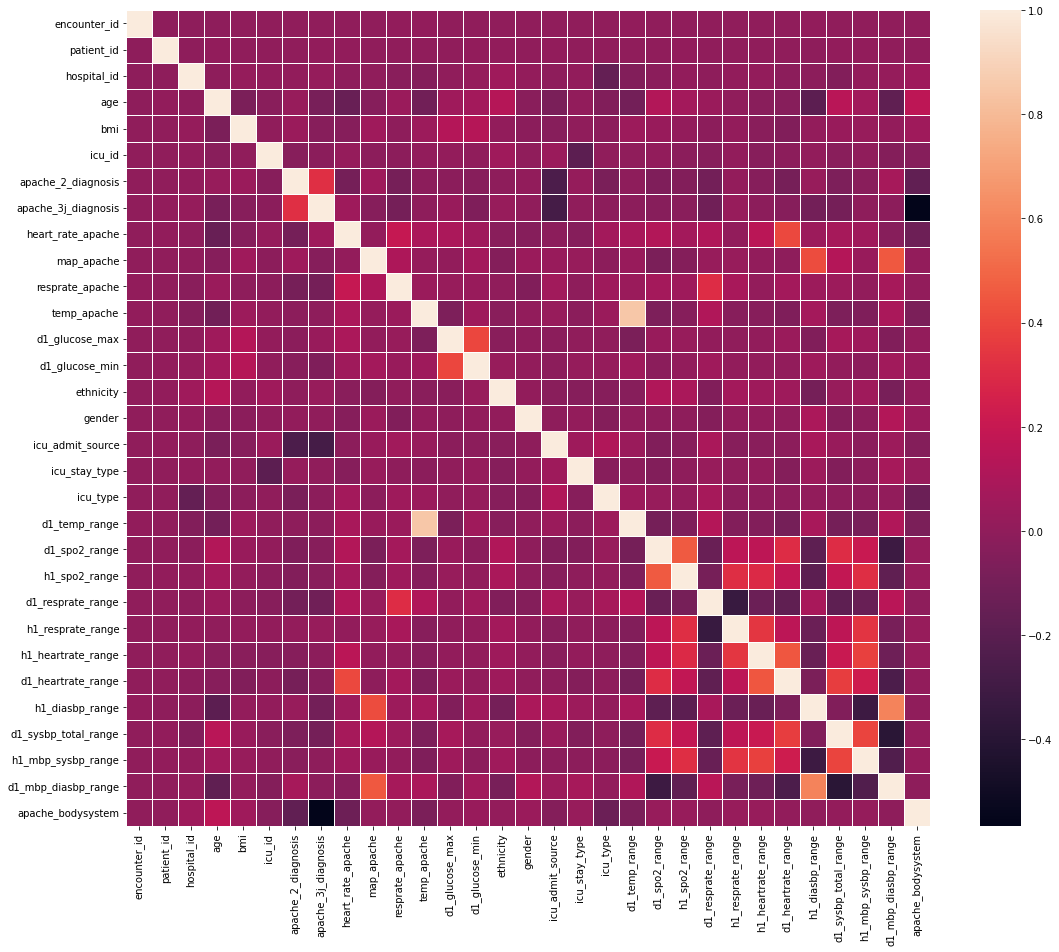

In [90]:
# Correlation plot
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(), linewidths=1)
plt.show()

In [91]:
# dropping all id columns
id_cols = [col for col in df if 'id' in col]
df.drop(columns=id_cols, inplace=True)
df.head()

,age,bmi,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_glucose_max,d1_glucose_min,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,hospital_death,elective_surgery,apache_post_operative,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,diabetes_mellitus,d1_temp_range,d1_spo2_range,h1_spo2_range,d1_resprate_range,h1_resprate_range,h1_heartrate_range,d1_heartrate_range,h1_diasbp_range,d1_sysbp_total_range,h1_mbp_sysbp_range,d1_mbp_diasbp_range,apache_bodysystem
0,68.0,3.166740,113.0,6.220610,118.0,3.713572,36.0,52420.2655,5.129899,4.700480,1,1,0.170216,1,0.043647,0,0,0,3.0,6.0,4.0,0.0,0.0,1.0,51475.167296,523640.0,378988.5,6.444652,0.351398,11.0,47.0,58.765893,57.999995,1.882352,36.619420,0.196561
1,77.0,3.347093,108.0,5.318169,120.0,3.850148,33.0,44448.5255,4.983607,4.859812,1,0,0.170216,1,0.551568,0,0,0,1.0,3.0,1.0,0.0,1.0,1.0,44069.239507,523640.0,236363.5,8.503492,0.098440,14.0,46.0,43.872866,91.999995,25.846149,29.435837,0.126575
2,25.0,3.494991,122.0,6.556821,102.0,4.234107,37.0,49430.8630,5.168425,4.748239,1,0,0.589448,1,0.551568,0,0,0,3.0,6.0,5.0,0.0,0.0,0.0,49427.225414,187621.0,187621.0,4.908958,0.211309,18.0,28.0,53.511364,42.999995,11.999996,51.594230,0.083407
3,81.0,3.162940,203.0,7.095918,114.0,4.110874,4.0,44448.5255,5.225747,4.488636,1,0,0.204039,1,0.043647,0,1,1,4.0,6.0,5.0,1.0,1.0,0.0,44069.194938,142625.0,29701.0,3.821946,0.080043,4.0,24.0,39.856865,73.999995,24.705878,51.507330,0.369001
4,20.0,3.407372,119.0,6.400274,60.0,4.644391,16.0,49430.8630,5.168425,4.748239,1,1,0.589448,1,0.551568,0,0,0,4.0,6.0,5.0,0.0,0.0,0.0,49427.220164,115264.0,0.0,13.055561,0.260615,13.0,29.0,63.394830,26.999995,10.909086,64.929030,0.041887


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    91713 non-null  float64 
 1   bmi                    91713 non-null  float64 
 2   apache_2_diagnosis     91713 non-null  float64 
 3   apache_3j_diagnosis    91713 non-null  float64 
 4   heart_rate_apache      91713 non-null  float64 
 5   map_apache             91713 non-null  float64 
 6   resprate_apache        91713 non-null  float64 
 7   temp_apache            91713 non-null  float64 
 8   d1_glucose_max         91713 non-null  float64 
 9   d1_glucose_min         91713 non-null  float64 
 10  ethnicity              91713 non-null  int32   
 11  gender                 91713 non-null  int32   
 12  icu_admit_source       91713 non-null  float64 
 13  icu_stay_type          91713 non-null  int32   
 14  icu_type               91713 non-null 

In [93]:
# converting all values to float
for col in df:
    df[col] = df[col].astype('float')

### Upsampling

In [94]:
major = df.drop(columns='hospital_death', axis=1)
minor = df['hospital_death']

counter = Counter(minor)

for k, v in counter.items():
    per = 100*v/len(minor)
    print(f"Class={k}, n={v} ({per:.2f}%)")

Class=0.0, n=83798 (91.37%)
Class=1.0, n=7915 (8.63%)


In [95]:
oversample = SMOTE()

major, minor = oversample.fit_resample(major, minor)

counter = Counter(minor)

for k, v in counter.items():
    per = 100*v/len(minor)
    print(f"Class={k}, n={v} ({per:.2f}%)")

Class=0.0, n=83798 (50.00%)
Class=1.0, n=83798 (50.00%)


In [96]:
# Creating dataframe
df = pd.concat([major, minor], axis=1)
print(df.shape)
df.head()

(167596, 36)


,age,bmi,apache_2_diagnosis,apache_3j_diagnosis,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_glucose_max,d1_glucose_min,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,elective_surgery,apache_post_operative,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,diabetes_mellitus,d1_temp_range,d1_spo2_range,h1_spo2_range,d1_resprate_range,h1_resprate_range,h1_heartrate_range,d1_heartrate_range,h1_diasbp_range,d1_sysbp_total_range,h1_mbp_sysbp_range,d1_mbp_diasbp_range,apache_bodysystem,hospital_death
0,68.0,3.166740,113.0,6.220610,118.0,3.713572,36.0,52420.2655,5.129899,4.700480,1.0,1.0,0.170216,1.0,0.043647,0.0,0.0,3.0,6.0,4.0,0.0,0.0,1.0,51475.167296,523640.0,378988.5,6.444652,0.351398,11.0,47.0,58.765893,57.999995,1.882352,36.619420,0.196561,0.0
1,77.0,3.347093,108.0,5.318169,120.0,3.850148,33.0,44448.5255,4.983607,4.859812,1.0,0.0,0.170216,1.0,0.551568,0.0,0.0,1.0,3.0,1.0,0.0,1.0,1.0,44069.239507,523640.0,236363.5,8.503492,0.098440,14.0,46.0,43.872866,91.999995,25.846149,29.435837,0.126575,0.0
2,25.0,3.494991,122.0,6.556821,102.0,4.234107,37.0,49430.8630,5.168425,4.748239,1.0,0.0,0.589448,1.0,0.551568,0.0,0.0,3.0,6.0,5.0,0.0,0.0,0.0,49427.225414,187621.0,187621.0,4.908958,0.211309,18.0,28.0,53.511364,42.999995,11.999996,51.594230,0.083407,0.0
3,81.0,3.162940,203.0,7.095918,114.0,4.110874,4.0,44448.5255,5.225747,4.488636,1.0,0.0,0.204039,1.0,0.043647,1.0,1.0,4.0,6.0,5.0,1.0,1.0,0.0,44069.194938,142625.0,29701.0,3.821946,0.080043,4.0,24.0,39.856865,73.999995,24.705878,51.507330,0.369001,0.0
4,20.0,3.407372,119.0,6.400274,60.0,4.644391,16.0,49430.8630,5.168425,4.748239,1.0,1.0,0.589448,1.0,0.551568,0.0,0.0,4.0,6.0,5.0,0.0,0.0,0.0,49427.220164,115264.0,0.0,13.055561,0.260615,13.0,29.0,63.394830,26.999995,10.909086,64.929030,0.041887,0.0


In [97]:
# splitting data
y = df['hospital_death']
X = df.drop('hospital_death', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=y)

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# saving scaler
joblib.dump(scaler, 'scaler.sav')
X_test_scaled = scaler.transform(X_test)

In [99]:
def get_baseline_model(models, X, y, nsplits=10, scoring ='accuracy'):
    results=[]
    names = []
    
    for name, model in models:
        kfold = StratifiedKFold(n_splits=nsplits)

        cv_results = cross_val_score(model, 
                                     X, y, 
                                     cv=kfold, 
                                     scoring=scoring)
        results.append(cv_results)

        names.append(name)
        
        plot_dict = dict(zip(names, results))

        msg = f"{name} >> Average score: {round(cv_results.mean(),5)}"
        print(msg)

    # boxplot of models for comparison
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('Comparison of models', fontsize=20)
    ax = fig.add_subplot(111)
    mean_props=dict(marker="D", 
                    markersize=7, 
                    markerfacecolor='salmon', 
                    markeredgecolor='black', 
                    linewidth=2)
    box = plt.boxplot(results, 
                      vert=False, 
                      showmeans=True, 
                      meanprops=mean_props,
                      medianprops=dict(markeredgecolor='black'),
                      patch_artist=True)
    
    colors = ['mistyrose', 'lightgoldenrodyellow', 'lavender', 'papayawhip', 'lightgreen', 'thistle']
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.set_yticklabels(names)
    ax.set_xlabel(scoring)
    plt.show()

In [100]:
# Feeding some base models
models = []
models.append(('LOG', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB', XGBClassifier(eval_metric='logloss')))

LOG >> Average score: 0.78405
KNN >> Average score: 0.89126
DTC >> Average score: 0.91982
RFC >> Average score: 0.95836
XGB >> Average score: 0.95797


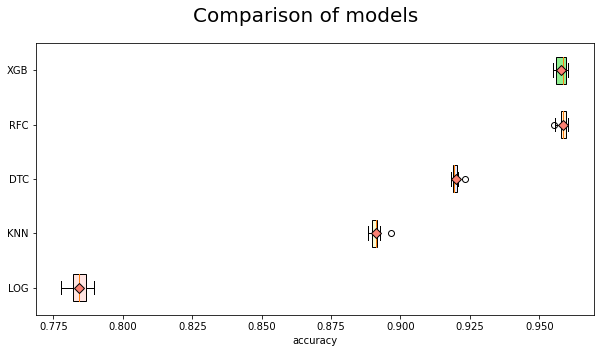

Wall time: 9min 30s


In [101]:
%%time
# Finding the best baseline model
get_baseline_model(models, X_train_scaled, y_train)

In [102]:
# selecting RandomForestClassifier as the base model
base_model = RandomForestClassifier()

In [103]:
# Function for calculating scores
def calculate_score(model):
    train_scores = cross_val_score(model, X_train_scaled, y_train, cv=10)
    test_scores = cross_val_score(model, X_test_scaled, y_test, cv=10)
    
    # Checking how the model fits the training data
    print("Accuracy on training data: ", np.round(np.mean(train_scores), 3))
    print("Accuracy on testing data: ", np.round(np.mean(test_scores), 3), "\n")

In [104]:
%%time
calculate_score(base_model)

Accuracy on training data:  0.958
Accuracy on testing data:  0.951 

Wall time: 5min 19s


In [105]:
# fitting model
base_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [106]:
# saving base model
joblib.dump(base_model, 'base_model.sav')

['base_model.sav']

In [107]:
# making a prediction for viewing classification metrics
y_pred = base_model.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)  # calculating auc score
# printing auc score and classification report
print(f"AUC: {auc}\n")
print(classification_report(y_test, y_pred))

AUC: 0.9592585493739711

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     20950
         1.0       0.98      0.93      0.96     20949

    accuracy                           0.96     41899
   macro avg       0.96      0.96      0.96     41899
weighted avg       0.96      0.96      0.96     41899



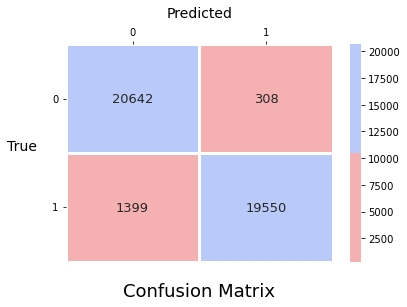

In [108]:
# function for plotting confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    confusionmatrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(confusionmatrix, 
                annot=True, 
                linewidth=3, 
                cmap=['#F5B1B1','#B9C9F9'], 
                fmt='.5g', 
                annot_kws={'fontsize':13})
    plt.xlabel("Confusion Matrix", fontsize=18, labelpad=20)
    ax.xaxis.tick_top()
    plt.ylabel("True", fontsize=14, rotation=0, labelpad=30)
    plt.yticks(rotation=0)
    plt.title("Predicted", fontsize=14, pad=10)
    plt.show()
# plotting confusion matrix   
plot_confusion_matrix(y_test, y_pred)

### Hyperparameter Tuning

In [109]:
# defining objective function
def rfc_objective(trial, data=X_train_scaled, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_jobs":-1,
        "criterion": trial.suggest_categorical("criterion",['gini', 'entropy']),
        "min_samples_split":trial.suggest_int("min_samples_split", 1, 10),
        "max_features": trial.suggest_categorical("max_features",['sqrt', 'log2']),
        "random_state": trial.suggest_int("random_state", 5, 50)
    }
    model = RandomForestClassifier(**param)
    # Setting random seed and kfolds for cross-validation
    kfolds = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, cv=kfolds, scoring="accuracy")
    return scores.mean()

In [110]:
# defining tuner
def tuner(objective, n=10, direction='maximize'):
    # Create Study object
    study = optuna.create_study(direction="maximize")
    # Optimize the study
    study.optimize(objective, n_trials=n)
    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    # Return best parameters for the model
    return best_params, best_score

In [111]:
%%time
rf_param, rf_score = tuner(rfc_objective)
tuned_model = RandomForestClassifier(**rf_param)

[I 2022-02-20 12:43:37,254] A new study created in memory with name: no-name-f58e0f4d-8c2f-41df-a1c7-58258bd245f5
[I 2022-02-20 12:44:49,256] Trial 0 finished with value: 0.946867289345902 and parameters: {'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 0 with value: 0.946867289345902.
[I 2022-02-20 12:45:49,160] Trial 1 finished with value: 0.9459126030098741 and parameters: {'criterion': 'gini', 'min_samples_split': 4, 'max_features': 'sqrt', 'random_state': 50}. Best is trial 0 with value: 0.946867289345902.
[I 2022-02-20 12:46:49,168] Trial 2 finished with value: 0.9457634465205956 and parameters: {'criterion': 'gini', 'min_samples_split': 4, 'max_features': 'log2', 'random_state': 38}. Best is trial 0 with value: 0.946867289345902.
[I 2022-02-20 12:47:58,762] Trial 3 finished with value: 0.9467240891190727 and parameters: {'criterion': 'entropy', 'min_samples_split': 5, 'max_features': 'sqrt', 'random_state': 42}. Best is t

Best score: 0.946867289345902
Optimized parameters: {'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'sqrt', 'random_state': 8}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
Wall time: 10min 1s


In [112]:
%%time
# Calculating scores
calculate_score(tuned_model)

Accuracy on training data:  0.958
Accuracy on testing data:  0.953 

Wall time: 6min 34s


In [113]:
# Selecting tuned model for model fitting
tuned_model.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=8)

In [114]:
# making a prediction for viewing classification metrics
y_pred = tuned_model.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)  # calculating auc score
# printing auc score and classification report
print(f"AUC: {auc}\n")
print(classification_report(y_test, y_pred))

AUC: 0.9596881368104904

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     20950
         1.0       0.99      0.93      0.96     20949

    accuracy                           0.96     41899
   macro avg       0.96      0.96      0.96     41899
weighted avg       0.96      0.96      0.96     41899



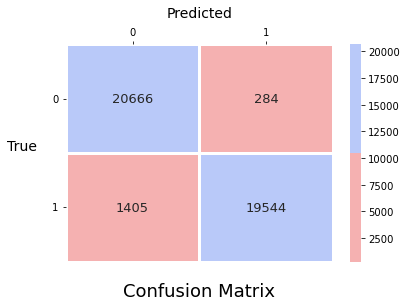

In [115]:
# plotting confusion matrix
plot_confusion_matrix(y_test, y_pred)

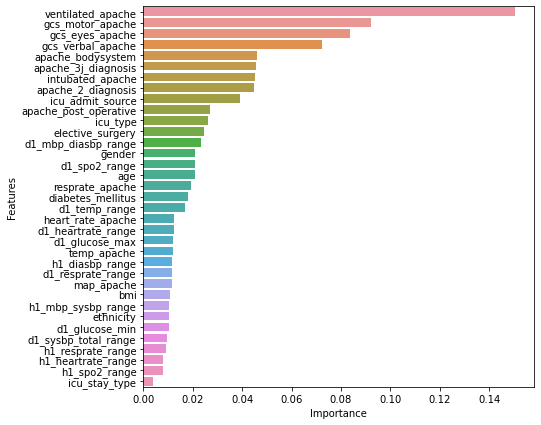

In [116]:
# Calculating feature importance
df_importance = pd.DataFrame()
df_importance['Features'] = X.columns
df_importance['Importance'] = base_model.feature_importances_
plt.figure(figsize=(7,7))
sns.barplot(data = df_importance.sort_values("Importance", ascending=False), y='Features', x='Importance');

In [117]:
#saving the model
joblib.dump(tuned_model, 'final_model.sav')

['final_model.sav']

## Explainable AI

In [118]:
X0, X1, y0, y1 = train_test_split(X_train, y_train, test_size=0.02, stratify=y_train)
print(X0.shape, X1.shape, y0.shape, y1.shape)

(123183, 35) (2514, 35) (123183,) (2514,)


In [119]:
tuned_model.fit(X1, y1)
explainer = shap.TreeExplainer(tuned_model)

In [120]:
%%time
shap_values = explainer.shap_values(X1)

Wall time: 20.6 s


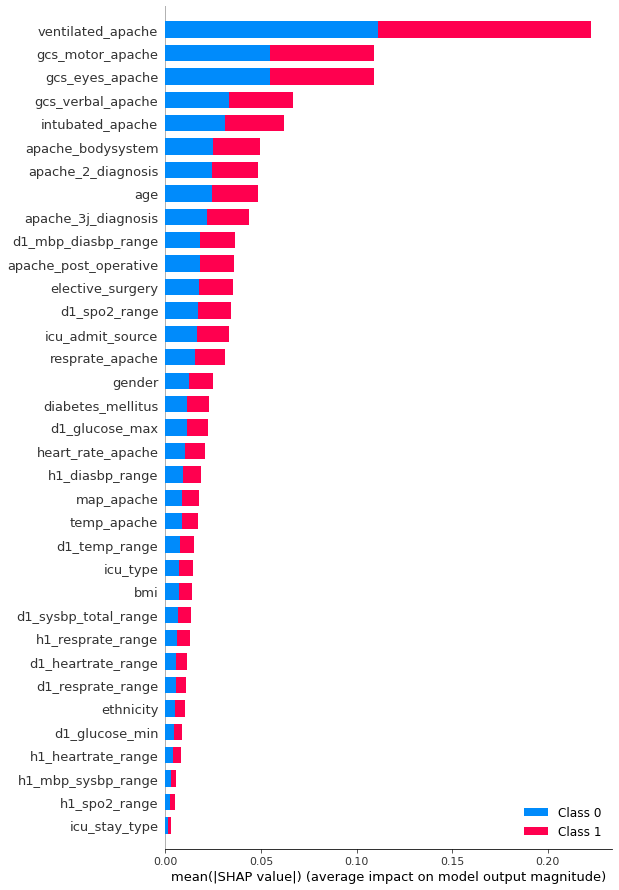

<Figure size 432x288 with 0 Axes>

In [128]:
# Plotting overall feature contribution
features = list(X_test.columns)
shap.summary_plot(shap_values, X1, feature_names=features, max_display=40)

In [132]:
# selecting top 8 features that contributes having the most impact on the model
selected_features = ['ventilated_apache', 
                     'gcs_motor_apache',
                     'gcs_eyes_apache',
                     'gcs_verbal_apache',
                     'intubated_apache',
                     'apache_bodysystem',
                     'apache_2_diagnosis',
                     'age']
# creating train and test sets using selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# scaling the train and test sets
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
# saving scaler
joblib.dump(scaler_selected, 'scaler_selected.sav')
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

In [133]:
tuned_model.fit(X_train_selected_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=8)

In [134]:
# making a prediction for viewing classification metrics
y_pred = tuned_model.predict(X_test_selected_scaled)
auc = roc_auc_score(y_test, y_pred)  # calculating auc score
# printing auc score and classification report
print(f"AUC: {auc}\n")
print(classification_report(y_test, y_pred))

AUC: 0.9431245469307151

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     20950
         1.0       0.97      0.92      0.94     20949

    accuracy                           0.94     41899
   macro avg       0.94      0.94      0.94     41899
weighted avg       0.94      0.94      0.94     41899



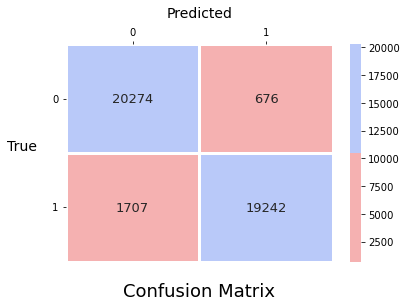

In [135]:
# plotting confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [163]:
X0, X1, y0, y1 = train_test_split(X_train_selected, y_train, test_size=0.02, stratify=y_train)
print(X0.shape, X1.shape, y0.shape, y1.shape)

(123183, 8) (2514, 8) (123183,) (2514,)


In [164]:
tuned_model.fit(X1, y1)
explainer = shap.TreeExplainer(tuned_model)

In [165]:
%%time
shap_values = explainer.shap_values(X1)

Wall time: 18.3 s


In [166]:
#saving shap values
joblib.dump(shap_values, 'shap_values.sav')

['shap_values.sav']

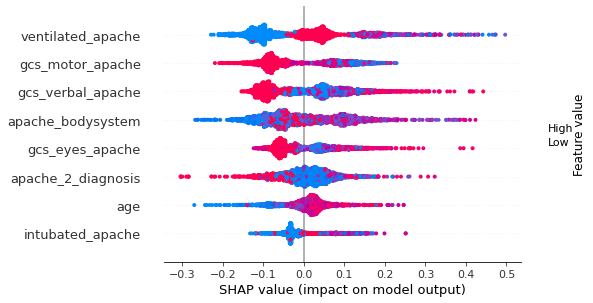

<Figure size 432x288 with 0 Axes>

In [167]:
features = list(X1.columns)
# feature contribution for class=1
shap.summary_plot(shap_values[1], X1, feature_names=features, max_display=40)
plt.savefig("feature_contribution.png")

In [168]:
# Testing Force plot
shap.initjs()
input_attributes = X0.iloc[1,:]

shap_explainer = shap.TreeExplainer(tuned_model)
shap_model_values = shap_explainer.shap_values(input_attributes)
shap_model_expected_values = shap_explainer.expected_value

# Plotting Force plots for class=1
shap.force_plot(shap_model_expected_values[1], 
                shap_model_values[1], 
                input_attributes,
                features,
                show=True)

### Functions for Preprocessing

In [ ]:
# function for winsorizing
def winsorize_feats(df, feats):
    caps = joblib.load('winsorizer.sav')
    # winsorizing features
    for item in caps:
        for feat in feats:
            if feat==item[0]:
                df[feat] = np.where(df[feat]<item[1], item[1],
                                       np.where(df[feat]>item[2], item[2], df[feat]))
    return df

In [ ]:
# function for creating apache_bodysystem
def create_apache_bodysystem(df):
    # creating a new feature 'apache_bodysystem' and dropping 'apache_2_bodysystem' and 'apache_3j_bodysystem'
    df['apache_bodysystem'] = 2 * df['apache_2_bodysystem'] * df['apache_3j_bodysystem']/(df['apache_2_bodysystem'] + df['apache_3j_bodysystem'] + 0.00001)
    df.drop(columns=['apache_2_bodysystem', 'apache_3j_bodysystem'], inplace=True)
    return df